In [11]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
#%load_ext watermark

In [12]:
# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [13]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}_standard/*_connectivity_matrix_standard.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

Found 19 connectivity matrices


In [ ]:
# subject level visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import pandas as pd

def create_all_visualizations(matrix, subject, output_dir, threshold=0.3):
    """
    Create comprehensive visualizations for a connectivity matrix.
    Preserves both positive and negative correlations in visualizations.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Enhanced Heatmap with positive and negative correlations
    plt.figure(figsize=(12, 10))
    matrix_plot = matrix.copy()
    np.fill_diagonal(matrix_plot, np.nan)
    sns.heatmap(matrix_plot, 
                cmap='RdBu_r',  # Red-Blue colormap: red for positive, blue for negative
                center=0,
                vmin=-0.8,
                vmax=0.8,
                square=True,
                xticklabels=False,
                yticklabels=False)
    plt.title(f'{subject} Connectivity Matrix')
    plt.savefig(f'{output_dir}/{subject}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Distribution Plots showing full correlation range
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Get lower triangle values (excluding diagonal)
    mask = np.triu(np.ones(matrix.shape)).astype(bool)
    flat_matrix = matrix[~mask]
    
    # Raw distribution showing both positive and negative correlations
    sns.histplot(flat_matrix, bins=50, ax=ax1)
    ax1.set_title('Distribution of Connectivity Values')
    ax1.set_xlabel('Correlation')
    ax1.set_ylabel('Count')
    ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)  # Add reference line at zero
    
    # Separate positive and negative correlations
    pos_corr = flat_matrix[flat_matrix > threshold]
    neg_corr = flat_matrix[flat_matrix < -threshold]
    ax1.axvline(x=threshold, color='r', linestyle='--', alpha=0.3)
    ax1.axvline(x=-threshold, color='b', linestyle='--', alpha=0.3)
    
    # Log distribution (absolute values but colored by sign)
    pos_log = np.log10(np.abs(pos_corr))
    neg_log = np.log10(np.abs(neg_corr))
    
    sns.histplot(pos_log, bins=25, ax=ax2, color='red', alpha=0.5, label='Positive')
    sns.histplot(neg_log, bins=25, ax=ax2, color='blue', alpha=0.5, label='Negative')
    ax2.set_title('Distribution of log10(|Connectivity|)\nby correlation sign')
    ax2.set_xlabel('log10(|Correlation|)')
    ax2.set_ylabel('Count')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{subject}_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Network Graph showing both positive and negative connections
    G = nx.from_numpy_array(matrix)
    
    # Keep edges above threshold (both positive and negative)
    edge_colors = []
    edge_weights = []
    
    for (u, v, d) in list(G.edges(data=True)):
        if abs(d['weight']) < threshold:
            G.remove_edge(u, v)
        else:
            # Color edges based on sign of correlation
            if d['weight'] > 0:
                edge_colors.append('red')
            else:
                edge_colors.append('blue')
            edge_weights.append(abs(d['weight']))
    
    if G.number_of_edges() > 0:  # Only create visualization if there are edges
        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
        
        # Draw network with colored edges for positive/negative correlations
        nx.draw(G, pos,
                node_size=100,
                node_color='lightgray',
                edge_color=edge_colors,
                width=[w*2 for w in edge_weights],
                alpha=0.6,
                with_labels=False)
        
        # Add legend
        plt.plot([], [], color='red', label='Positive correlation', linewidth=2)
        plt.plot([], [], color='blue', label='Negative correlation', linewidth=2)
        plt.legend()
        
        plt.title(f'Brain Network\nEdges: |correlation| > {threshold}\nRed: positive, Blue: negative')
        plt.savefig(f'{output_dir}/{subject}_network.png', dpi=300, bbox_inches='tight')
        plt.close()

# Load subject information and run visualizations
curr_dir = "."
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & 
                (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Process each subject
output_dir = 'figures/connectivity_viz'
os.makedirs(output_dir, exist_ok=True)

for sub in subs:
    try:
        matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
        create_all_visualizations(matrix, sub, output_dir)
        print(f"Completed visualizations for subject {sub}")
    except Exception as e:
        print(f"Error processing subject {sub}: {str(e)}")


Group Average Statistics:
Mean correlation: 0.054
Standard deviation: 0.120
Min correlation: -0.242
Max correlation: 0.851


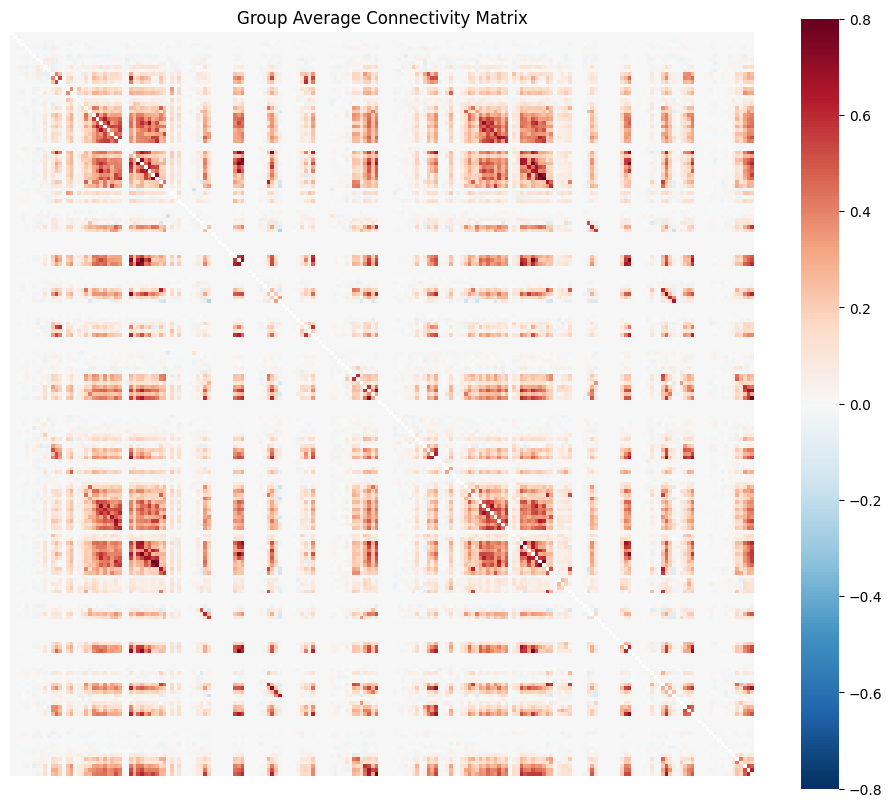

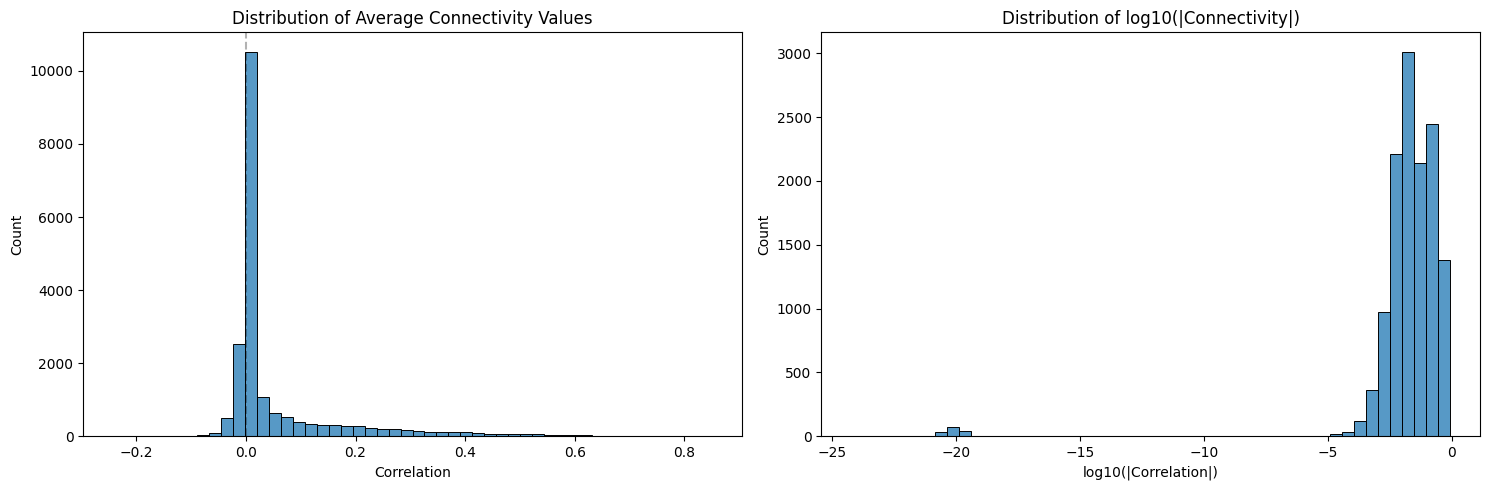

In [1]:
#group average visualizations

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import pandas as pd

# Load subject information
curr_dir = "."
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & 
                (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Create array to store all matrices
first_matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{subs[0]}_connectivity_matrix_standard.npy')
all_matrices = np.zeros((len(subs), *first_matrix.shape))

# Load all matrices
for i, sub in enumerate(subs):
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    all_matrices[i] = matrix

# Calculate average matrix
avg_matrix = np.mean(all_matrices, axis=0)

# Create visualizations
output_dir = 'figures/connectivity_viz'
os.makedirs(output_dir, exist_ok=True)

# 1. Enhanced Heatmap of average connectivity
plt.figure(figsize=(12, 10))
matrix_plot = avg_matrix.copy()
np.fill_diagonal(matrix_plot, np.nan)
sns.heatmap(matrix_plot, 
            cmap='RdBu_r',
            center=0,
            vmin=-0.8,
            vmax=0.8,
            square=True,
            xticklabels=False,
            yticklabels=False)
plt.title('Group Average Connectivity Matrix')
plt.savefig(f'{output_dir}/group_average_heatmap.png', dpi=300, bbox_inches='tight')
#plt.close()

# 2. Distribution Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Get lower triangle values (excluding diagonal)
mask = np.triu(np.ones(avg_matrix.shape)).astype(bool)
flat_matrix = avg_matrix[~mask]

# Raw distribution
sns.histplot(flat_matrix, bins=50, ax=ax1)
ax1.set_title('Distribution of Average Connectivity Values')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Count')
ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Log distribution of absolute values
log_matrix = np.log10(np.abs(flat_matrix[flat_matrix != 0]))
sns.histplot(log_matrix, bins=50, ax=ax2)
ax2.set_title('Distribution of log10(|Connectivity|)')
ax2.set_xlabel('log10(|Correlation|)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.savefig(f'{output_dir}/group_average_distributions.png', dpi=300, bbox_inches='tight')
#plt.close()

# 3. Network Graph
threshold = 0.3  # Adjust this threshold as needed
G = nx.from_numpy_array(avg_matrix)

# Keep edges above threshold (both positive and negative)
edge_colors = []
edge_weights = []

for (u, v, d) in list(G.edges(data=True)):
    if abs(d['weight']) < threshold:
        G.remove_edge(u, v)
    else:
        edge_colors.append('red' if d['weight'] > 0 else 'blue')
        edge_weights.append(abs(d['weight']))

if G.number_of_edges() > 0:
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    nx.draw(G, pos,
            node_size=100,
            node_color='lightgray',
            edge_color=edge_colors,
            width=[w*2 for w in edge_weights],
            alpha=0.6,
            with_labels=False)
    
    plt.plot([], [], color='red', label='Positive correlation', linewidth=2)
    plt.plot([], [], color='blue', label='Negative correlation', linewidth=2)
    plt.legend()
    
    plt.title(f'Group Average Brain Network\nEdges: |correlation| > {threshold}\nRed: positive, Blue: negative')
    plt.savefig(f'{output_dir}/group_average_network.png', dpi=300, bbox_inches='tight')
    plt.close()

# Print some basic statistics about the average connectivity matrix
print("\nGroup Average Statistics:")
print(f"Mean correlation: {np.mean(flat_matrix):.3f}")
print(f"Standard deviation: {np.std(flat_matrix):.3f}")
print(f"Min correlation: {np.min(flat_matrix):.3f}")
print(f"Max correlation: {np.max(flat_matrix):.3f}")

 ...done. (0 seconds, 0 min)


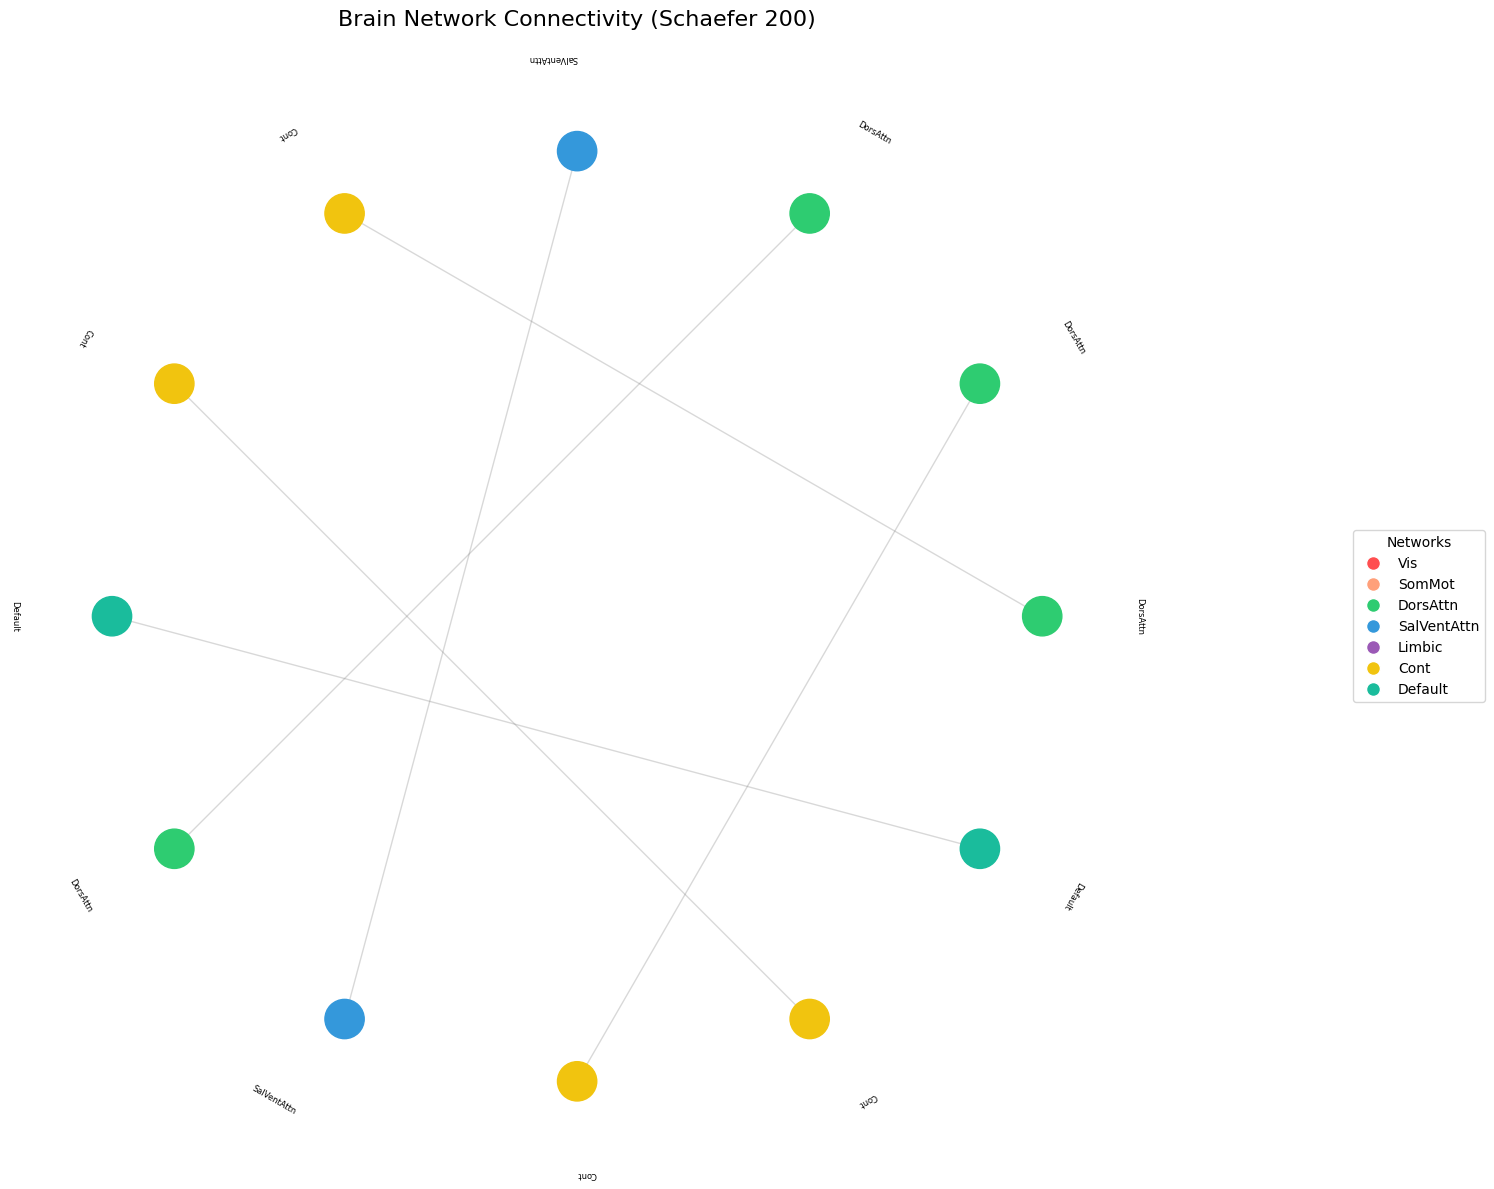

In [25]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets

# Load Schaefer atlas and get labels
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
labels = [label.decode('utf-8') for label in atlas.labels]

# Create figure
plt.figure(figsize=(15, 12))

# Network preparation
G_sparse = nx.from_numpy_array(matrix)
G_sparse.remove_edges_from(list(nx.selfloop_edges(G_sparse)))

# Threshold weak connections
threshold = 0.75
for (u, v, d) in list(G_sparse.edges(data=True)):
    if abs(d['weight']) < threshold:
        G_sparse.remove_edge(u, v)

# Remove isolated nodes
G_sparse.remove_nodes_from(list(nx.isolates(G_sparse)))

# Relabel nodes with Schaefer labels
G_sparse = nx.relabel_nodes(G_sparse, 
                          {i: labels[i] for i in range(len(labels))})

# Schaefer network colors (7-network parcellation)
network_colors = {
    'Vis': '#FF4E50',     # Visual
    'SomMot': '#FFA07A',  # Somatomotor
    'DorsAttn': '#2ECC71', # Dorsal Attention
    'SalVentAttn': '#3498DB', # Salience/Ventral Attention
    'Limbic': '#9B59B6',   # Limbic
    'Cont': '#F1C40F',     # Control
    'Default': '#1ABC9C'   # Default Mode
}

# Get node colors based on network membership
node_colors = []
for node in G_sparse.nodes():
    for network, color in network_colors.items():
        if network in node:
            node_colors.append(color)
            break
    else:
        node_colors.append('#95A5A6')  # Default gray

# Create circular layout
pos = nx.circular_layout(G_sparse)

# Draw edges
nx.draw_networkx_edges(G_sparse, pos, 
                      edge_color='gray',
                      alpha=0.3,
                      width=1)

# Draw nodes
nx.draw_networkx_nodes(G_sparse, pos,
                      node_color=node_colors,
                      node_size=800)

# Add rotated labels
for node, (x, y) in pos.items():
    # Simplify label by removing hemisphere and network prefix
    simple_label = node.split('_')[2] if '_' in node else node
    
    angle = np.arctan2(y, x)
    angle = np.rad2deg(angle)
    if x >= 0:
        ha = 'left'
        angle -= 90
    else:
        ha = 'right'
        angle += 90
    plt.text(x*1.2, y*1.2, simple_label,
            rotation=angle,
            ha=ha,
            va='center',
            fontsize=6)

# Add title
plt.title("Brain Network Connectivity (Schaefer 200)", pad=20, size=16)

# Add legend for networks
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=network, markersize=10)
                  for network, color in network_colors.items()]
plt.legend(handles=legend_elements, 
          bbox_to_anchor=(1.2, 0.5), 
          loc='center left', 
          title='Networks')

# Adjust layout
plt.axis('equal')
plt.axis('off')
plt.tight_layout()

# Display the plot
plt.show()

Number of edges: 6
Number of nodes: 12


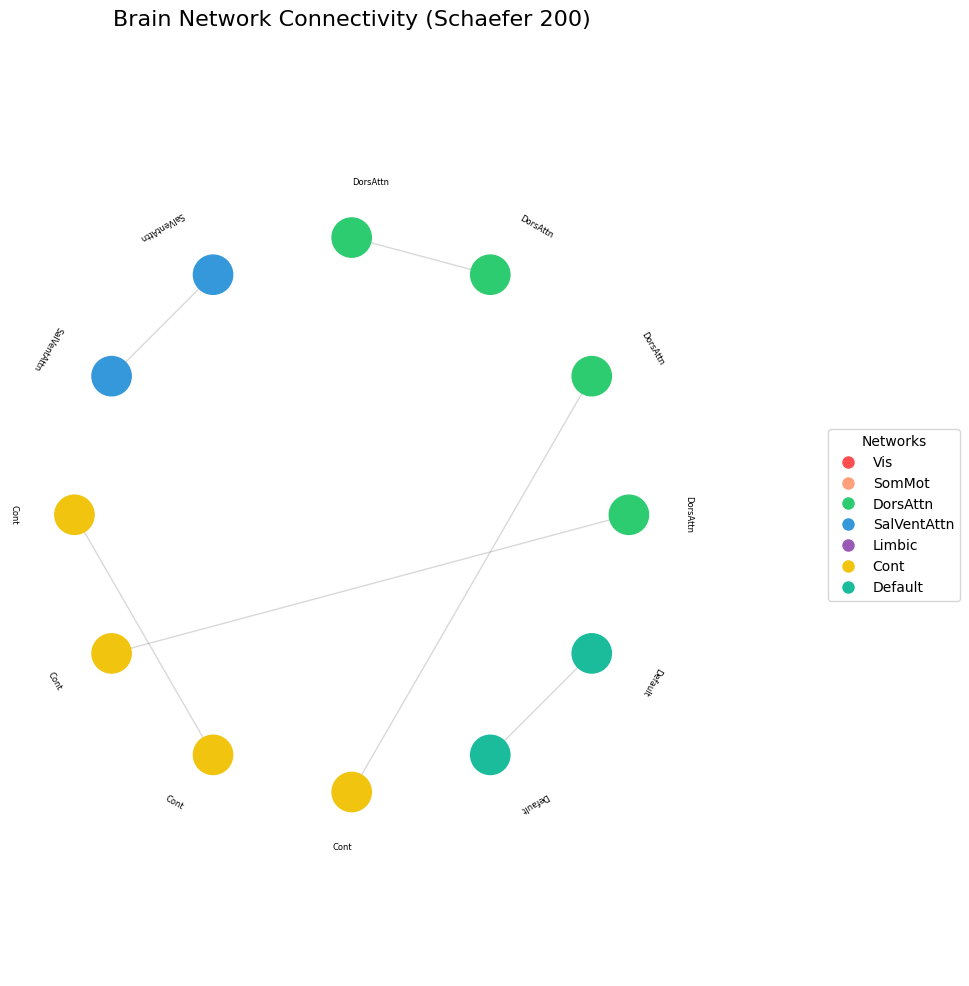

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets

# Load Schaefer atlas and get labels
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
labels = [label.decode('utf-8') for label in atlas.labels]

# Create figure
plt.figure(figsize=(10, 10))

# Network preparation with explicit self-loop removal
G_sparse = nx.from_numpy_array(matrix)

# Remove self-loops both from matrix and graph
np.fill_diagonal(matrix, 0)  # Remove diagonal elements from matrix
G_sparse = nx.from_numpy_array(matrix)  # Recreate graph
G_sparse.remove_edges_from(list(nx.selfloop_edges(G_sparse)))  # Extra check for self-loops

threshold = 0.75
for (u, v, d) in list(G_sparse.edges(data=True)):
    if abs(d['weight']) < threshold or u == v:  # Additional self-loop check
        G_sparse.remove_edge(u, v)

G_sparse.remove_nodes_from(list(nx.isolates(G_sparse)))
G_sparse = nx.relabel_nodes(G_sparse, 
                          {i: labels[i] for i in range(len(labels))})

# Define network colors for Schaefer networks
network_colors = {
    'Vis': '#FF4E50',     # Visual
    'SomMot': '#FFA07A',  # Somatomotor
    'DorsAttn': '#2ECC71', # Dorsal Attention
    'SalVentAttn': '#3498DB', # Salience/Ventral Attention
    'Limbic': '#9B59B6',   # Limbic
    'Cont': '#F1C40F',     # Control
    'Default': '#1ABC9C'   # Default Mode
}

# Group nodes by network
network_groups = {}
for network in network_colors.keys():
    network_groups[network] = sorted([n for n in G_sparse.nodes() if network in n])

# Custom circular layout
def create_grouped_layout(network_groups, network_order):
    pos = {}
    total_nodes = sum(len(group) for group in network_groups.values())
    current_angle = 0
    spacing = 2 * np.pi / total_nodes
    
    for network in network_order:
        nodes = network_groups[network]
        for node in nodes:
            x = np.cos(current_angle)
            y = np.sin(current_angle)
            pos[node] = np.array([x, y])
            current_angle += spacing
            
    return pos

# Define network order for Schaefer networks
network_order = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
pos = create_grouped_layout(network_groups, network_order)

# Create ordered node list and colors
ordered_nodes = []
node_colors = []
for network in network_order:
    nodes = network_groups[network]
    ordered_nodes.extend(nodes)
    node_colors.extend([network_colors[network]] * len(nodes))

# Draw edges
edge_list = [(u, v) for (u, v) in G_sparse.edges() if u != v]  # Explicit filtering of self-loops
nx.draw_networkx_edges(G_sparse, pos, 
                      edgelist=edge_list,
                      edge_color='gray',
                      alpha=0.3,
                      width=1)

# Draw nodes
nx.draw_networkx_nodes(G_sparse, pos,
                      nodelist=ordered_nodes,
                      node_color=node_colors,
                      node_size=800)  # Reduced node size for 200 regions

# Add rotated labels
for node, (x, y) in pos.items():
    # Simplify label by removing hemisphere and network prefix
    simple_label = node.split('_')[2] if '_' in node else node
    
    angle = np.arctan2(y, x)
    angle = np.rad2deg(angle)
    if x >= 0:
        ha = 'left'
        angle -= 90
    else:
        ha = 'right'
        angle += 90
    plt.text(x*1.2, y*1.2, simple_label,
             rotation=angle,
             ha=ha,
             va='center',
             fontsize=6)  # Reduced font size for better fit

# Add title
plt.title("Brain Network Connectivity (Schaefer 200)", pad=20, size=16)

# Add legend for node colors with improved positioning
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=network, markersize=10)
                  for network, color in network_colors.items()]
plt.legend(handles=legend_elements, 
          bbox_to_anchor=(1.2, 0.5), 
          loc='center left',
          title='Networks')

# Adjust layout
plt.axis('equal')
plt.axis('off')
plt.tight_layout()

# Print debug information
print("Number of edges:", len(G_sparse.edges()))
print("Number of nodes:", len(G_sparse.nodes()))

Network after thresholding and removing self-loops:
Number of nodes: 200
Number of edges: 6

After removing isolated nodes:
Number of nodes remaining: 12
Number of edges: 6


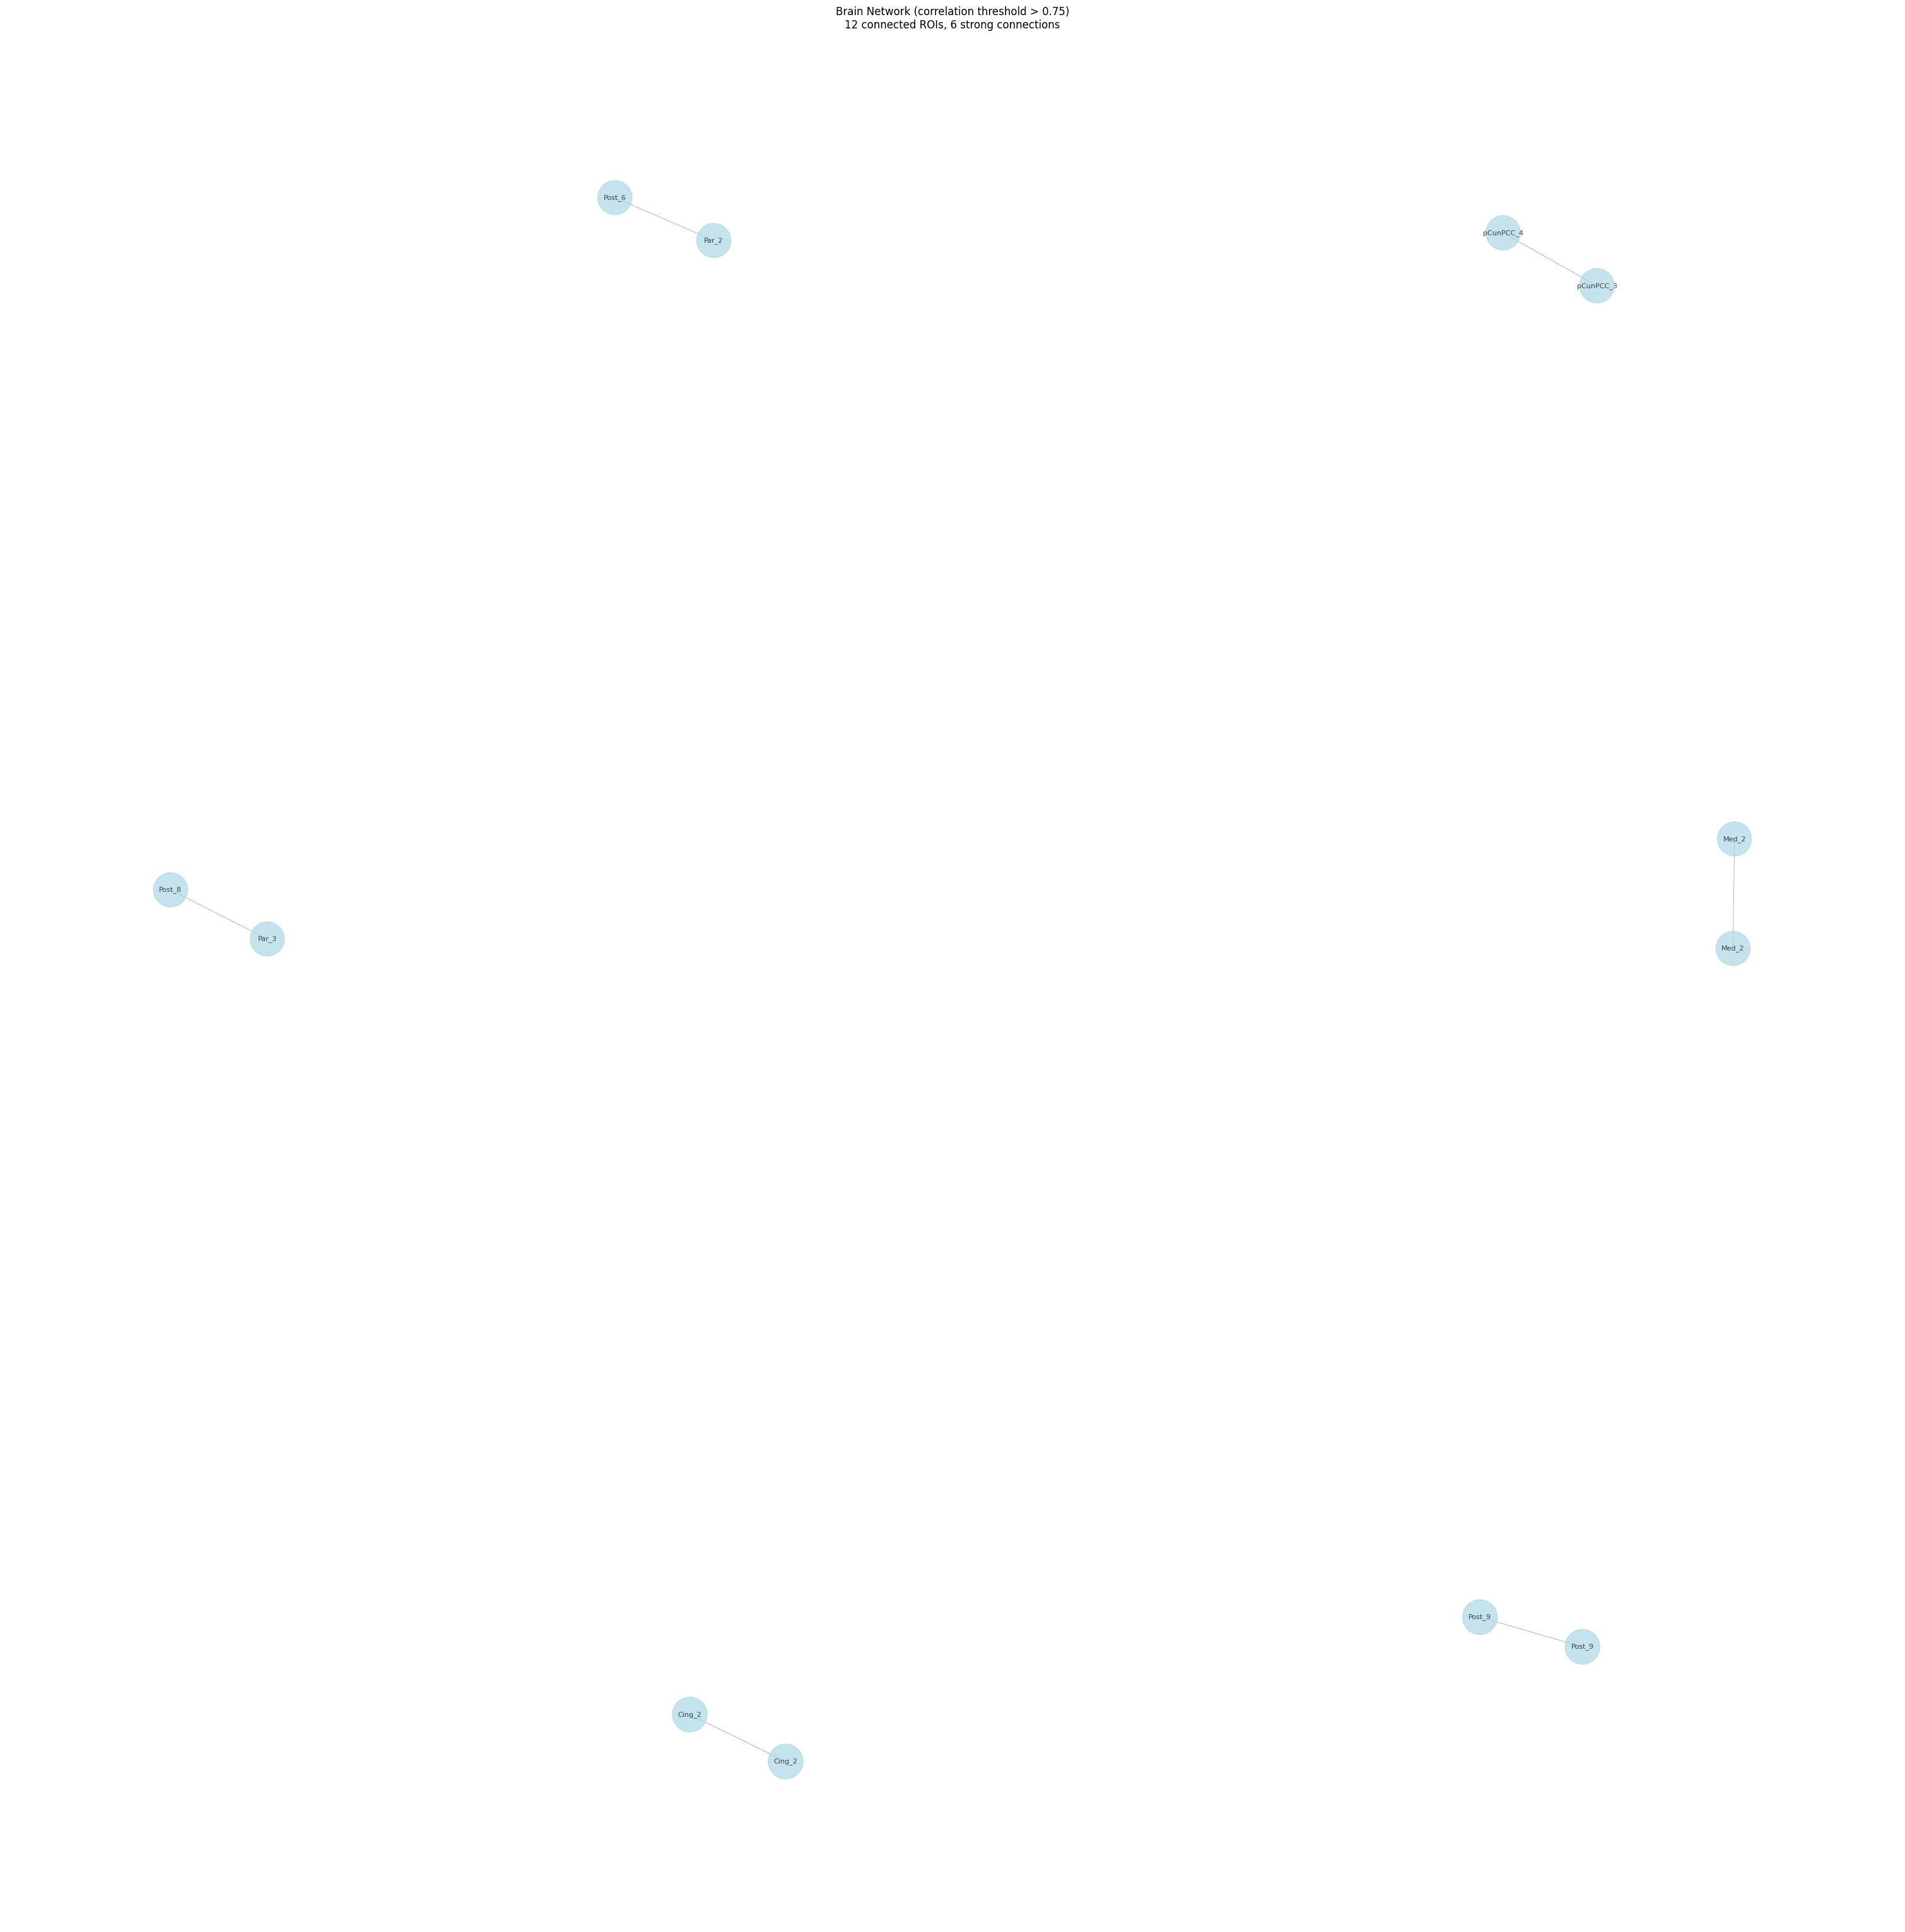

In [27]:
#graph theory analysis and visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# Get Schaefer atlas and labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)
labels = schaefer_atlas.labels

# Clean up labels - remove the prefix and hemisphere info for clarity
clean_labels = [label.decode('utf-8').split('_')[-2] + '_' + label.decode('utf-8').split('_')[-1] 
                for label in labels]

# First create the thresholded matrix
matrix_thresholded = matrix.copy()
threshold = 0.75
matrix_thresholded[matrix_thresholded <= threshold] = 0

# Create graph from thresholded matrix
G = nx.from_numpy_array(matrix_thresholded)

# Remove self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

print(f"Network after thresholding and removing self-loops:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Remove isolated nodes (nodes with no connections)
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

print(f"\nAfter removing isolated nodes:")
print(f"Number of nodes remaining: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Create label dictionary for remaining nodes
node_labels = {node: clean_labels[node] for node in G.nodes()}

# Calculate normalized node strengths
strength = G.degree(weight='weight')
node_sizes = [val * 2000 for (node, val) in strength]  # Scale for visibility

# Set up the visualization
plt.figure(figsize=(30, 30))

# Calculate edge widths
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=100)

# Draw network
nx.draw(G, pos, 
        with_labels=True, 
        width=np.power(edgewidth, 2),  # Square the edge widths
        edge_color='grey', 
        node_size=node_sizes,
        labels=node_labels,
        font_color='black', 
        node_color='lightblue',  # Can be modified based on your needs
        alpha=0.7, 
        font_size=8)

plt.title(f'Brain Network (correlation threshold > {threshold})\n'
          f'{G.number_of_nodes()} connected ROIs, {G.number_of_edges()} strong connections')

plt.show()

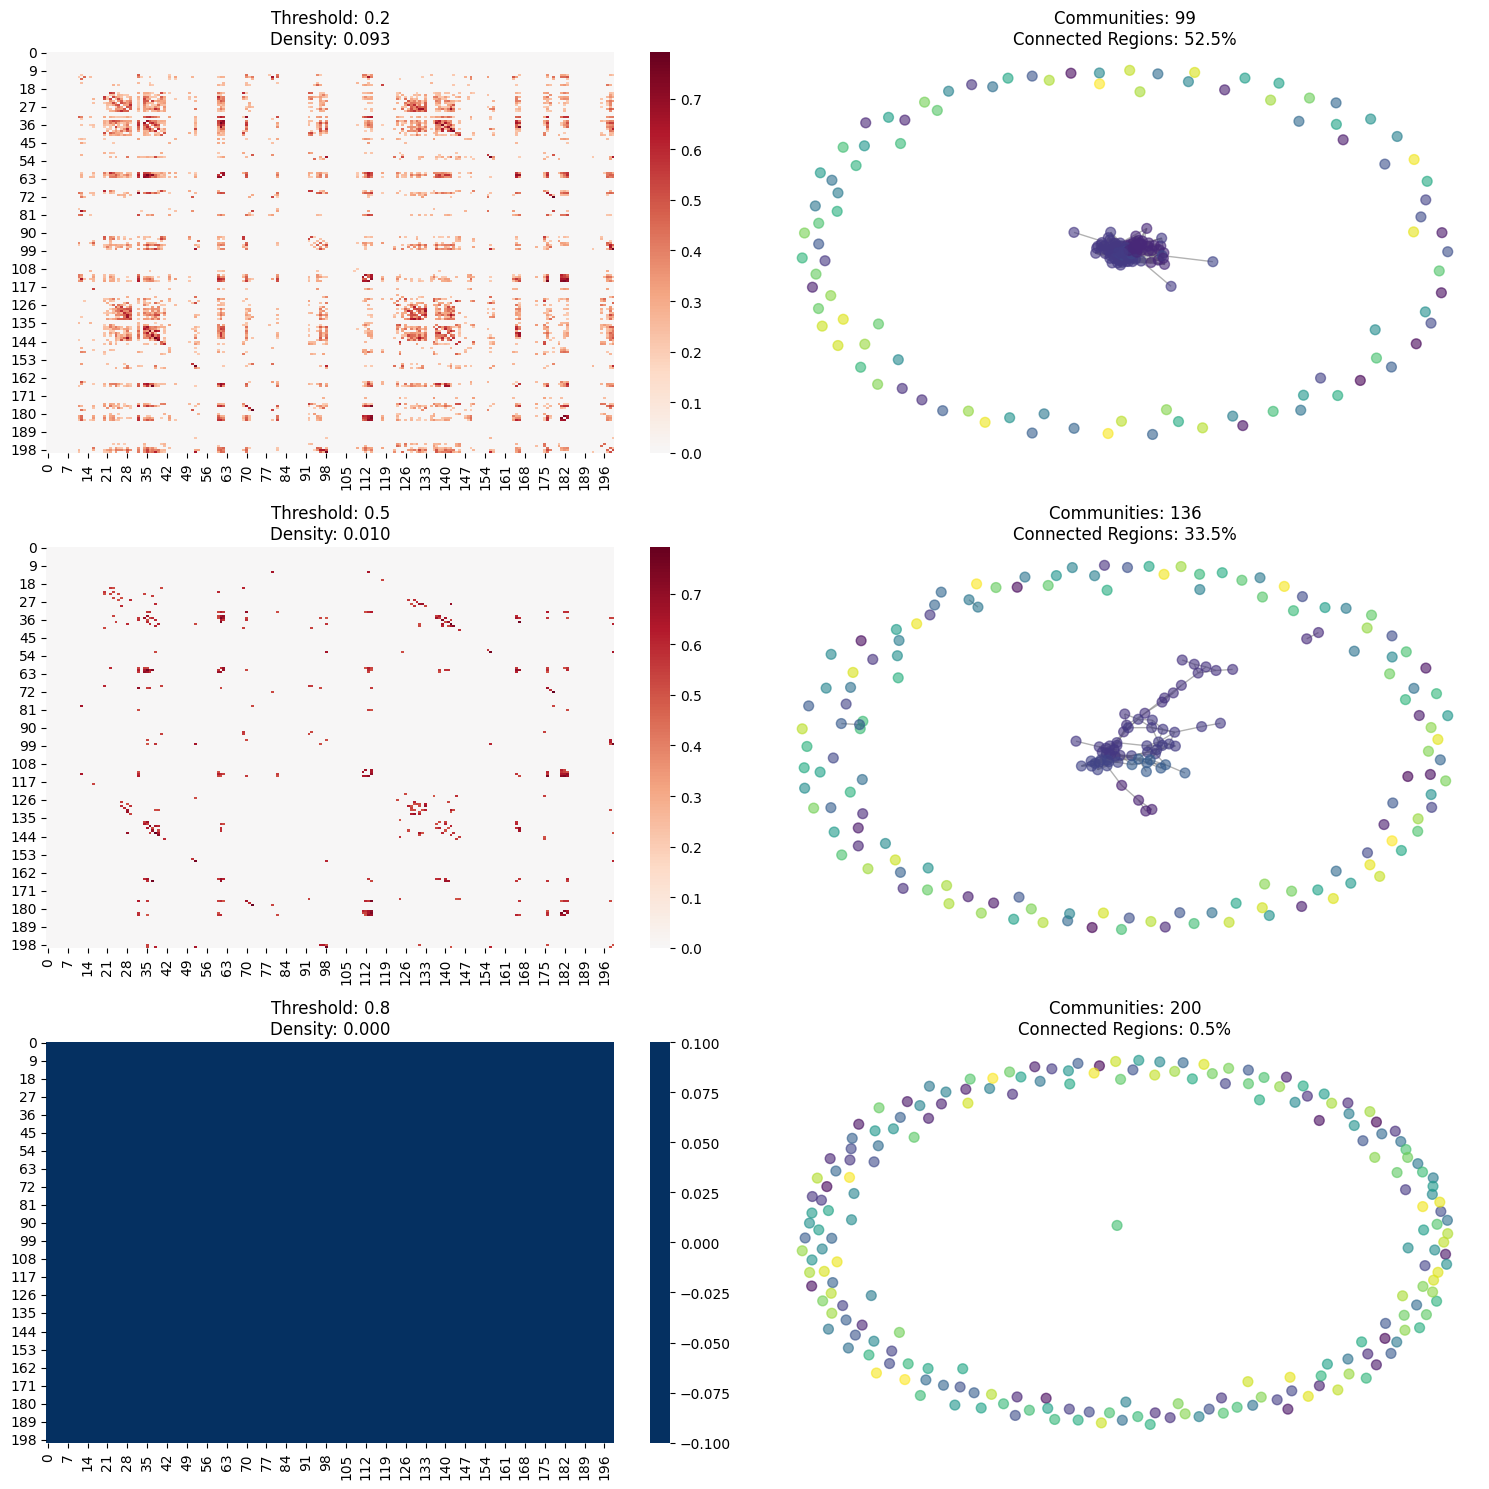


Summary of findings:
-------------------
Total brain regions analyzed: 200

What the thresholds tell us:

At threshold 0.2:
- Kept 9.3% of all possible connections
- Found 99 distinct brain communities
- 1851 strong connections between regions

At threshold 0.5:
- Kept 1.0% of all possible connections
- Found 135 distinct brain communities
- 201 strong connections between regions

At threshold 0.8:
- Kept 0.0% of all possible connections
- Found 200 distinct brain communities
- 0 strong connections between regions


In [28]:
# graph theory analysis and visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import community
from nilearn import datasets

def analyze_brain_connectivity(matrix, labels, thresholds=[0.2, 0.5, 0.8]):
    """
    Analyze how different correlation thresholds affect brain network properties.
    
    Args:
        matrix: Correlation matrix of brain regions
        labels: Brain region labels
        thresholds: List of correlation thresholds to test
    """
    # Set up figure for our results
    fig, axes = plt.subplots(len(thresholds), 2, figsize=(15, 5*len(thresholds)))
    
    for idx, threshold in enumerate(thresholds):
        # Create thresholded matrix
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh <= threshold] = 0
        
        # Create graph
        G = nx.from_numpy_array(matrix_thresh)
        G.remove_edges_from(list(nx.selfloop_edges(G)))
        
        # Calculate basic properties
        density = nx.density(G)
        communities = community.best_partition(G, weight='weight')
        n_communities = len(set(communities.values()))
        
        # Get largest connected group of brain regions
        largest_component = max(nx.connected_components(G), key=len)
        connectivity_ratio = len(largest_component) / G.number_of_nodes()
        
        # Plot correlation matrix
        sns.heatmap(matrix_thresh, ax=axes[idx, 0], cmap='RdBu_r', center=0)
        axes[idx, 0].set_title(f'Threshold: {threshold}\nDensity: {density:.3f}')
        
        # Plot network
        nx.draw(G, ax=axes[idx, 1], 
                node_color=list(communities.values()),
                node_size=50,
                edge_color='gray',
                alpha=0.6)
        axes[idx, 1].set_title(f'Communities: {n_communities}\nConnected Regions: {connectivity_ratio:.1%}')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary of findings:")
    print("-------------------")
    print(f"Total brain regions analyzed: {len(labels)}")
    print("\nWhat the thresholds tell us:")
    for threshold in thresholds:
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh <= threshold] = 0
        G = nx.from_numpy_array(matrix_thresh)
        density = nx.density(G)
        n_communities = len(set(community.best_partition(G, weight='weight').values()))
        print(f"\nAt threshold {threshold}:")
        print(f"- Kept {(density*100):.1f}% of all possible connections")
        print(f"- Found {n_communities} distinct brain communities")
        
        # Count strong connections
        strong_connections = np.sum(matrix_thresh > 0) / 2  # divide by 2 because matrix is symmetric
        print(f"- {strong_connections:.0f} strong connections between regions")

# Run the analysis
analyze_brain_connectivity(matrix, clean_labels)

In [57]:
# largest brain networks
def analyze_communities(matrix, labels, threshold=0.5):
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create graph and find communities
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Group regions by community
    community_regions = {}
    for node, comm_id in communities.items():
        if comm_id not in community_regions:
            community_regions[comm_id] = []
        community_regions[comm_id].append(labels[node])
    
    # Print largest communities
    print("Largest brain networks found:")
    for comm_id, regions in sorted(community_regions.items(), 
                                 key=lambda x: len(x[1]), 
                                 reverse=True)[:5]:
        print(f"\nNetwork {comm_id} ({len(regions)} regions):")
        print(", ".join(regions[:5]) + "..." if len(regions) > 5 else "")

# Run analysis
analyze_communities(matrix, clean_labels)

Largest brain networks found:

Network 24 (41 regions):
SomMot_20, SomMot_21, SomMot_22, SomMot_25, SomMot_26...

Network 20 (36 regions):
SomMot_2, SomMot_3, SomMot_4, SomMot_5, SomMot_6...

Network 3 (33 regions):
Vis_7, Vis_10, Vis_11, Vis_13, Vis_16...

Network 21 (33 regions):
SomMot_13, SomMot_14, SomMot_15, SomMot_17, Post_5...

Network 22 (32 regions):
SomMot_16, SomMot_19, FEF_1, FEF_2, FEF_3...


In [ ]:
#brain network composition
def analyze_network_composition(matrix, labels, threshold=0.5):
    # Create thresholded matrix and find communities
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Analyze composition of each community
    community_composition = {}
    for node, comm_id in communities.items():
        if comm_id not in community_composition:
            community_composition[comm_id] = {}
        
        # Get the network type (before the underscore)
        network_type = labels[node].split('_')[0]
        community_composition[comm_id][network_type] = community_composition[comm_id].get(network_type, 0) + 1
    
    # Print composition of largest communities
    print("Detailed composition of largest networks:")
    for comm_id in [20, 22, 21, 3, 23]:  # Our largest networks
        print(f"\nNetwork {comm_id} composition:")
        total = sum(community_composition[comm_id].values())
        for network, count in sorted(community_composition[comm_id].items(), key=lambda x: x[1], reverse=True):
            percentage = (count/total) * 100
            print(f"{network}: {count} regions ({percentage:.1f}%)")

# Run the analysis
analyze_network_composition(matrix, clean_labels)

Detailed composition of largest networks:

Network 20 composition:
SomMot: 19 regions (38.0%)
FrOperIns: 9 regions (18.0%)
Par: 5 regions (10.0%)
TempOccPar: 4 regions (8.0%)
Temp: 4 regions (8.0%)
PFC: 3 regions (6.0%)
ParOper: 2 regions (4.0%)
PFCv: 2 regions (4.0%)
Post: 1 regions (2.0%)
TempOcc: 1 regions (2.0%)

Network 22 composition:
Med: 11 regions (35.5%)
pCunPCC: 8 regions (25.8%)
SomMot: 7 regions (22.6%)
Post: 2 regions (6.5%)
Cing: 2 regions (6.5%)
pCun: 1 regions (3.2%)

Network 21 composition:
SomMot: 14 regions (43.8%)
PFCl: 5 regions (15.6%)
FEF: 4 regions (12.5%)
PrCv: 3 regions (9.4%)
Post: 2 regions (6.2%)
ParOper: 2 regions (6.2%)
PFC: 1 regions (3.1%)
PrC: 1 regions (3.1%)

Network 3 composition:
Vis: 19 regions (57.6%)
pCunPCC: 12 regions (36.4%)
pCun: 2 regions (6.1%)

Network 23 composition:
SomMot: 30 regions (69.8%)
Med: 4 regions (9.3%)
Post: 3 regions (7.0%)
FEF: 3 regions (7.0%)
PFC: 1 regions (2.3%)
PFCl: 1 regions (2.3%)
PFCdPFCm: 1 regions (2.3%)


In [ ]:
# community structure
def visualize_community_structure(matrix, labels, threshold=0.5):
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create graph and find communities
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Create a summary of each community's size and main type
    community_summary = {}
    for node, comm_id in communities.items():
        if comm_id not in community_summary:
            community_summary[comm_id] = {'size': 0, 'types': {}}
        
        community_summary[comm_id]['size'] += 1
        node_type = labels[node].split('_')[0]
        community_summary[comm_id]['types'][node_type] = community_summary[comm_id]['types'].get(node_type, 0) + 1
    
    # Print summary sorted by size
    print("Community Structure at Threshold 0.5:")
    print("------------------------------------")
    for comm_id, info in sorted(community_summary.items(), key=lambda x: x[1]['size'], reverse=True):
        main_type = max(info['types'].items(), key=lambda x: x[1])[0]
        print(f"\nCommunity {comm_id}: {info['size']} nodes")
        print(f"Dominant type: {main_type} ({info['types'][main_type]} nodes)")
        if len(info['types']) > 1:
            print("Also contains:", ', '.join([f"{k} ({v})" for k, v in info['types'].items() if k != main_type]))

# Run the visualization
visualize_community_structure(matrix, clean_labels)

Community Structure at Threshold 0.5:
------------------------------------

Community 19: 59 nodes
Dominant type: SomMot (23 nodes)
Also contains: Post (1), ParOper (2), TempOcc (1), FrOperIns (13), Temp (10), Par (4), PFC (2), TempOccPar (2), PFCv (1)

Community 20: 45 nodes
Dominant type: SomMot (15 nodes)
Also contains: Post (13), PrCv (2), ParOper (2), Par (9), TempOccPar (2), PrC (1), PFCl (1)

Community 22: 45 nodes
Dominant type: PFCl (20 nodes)
Also contains: SomMot (1), FEF (6), PrCv (1), PFCmp (2), PFC (9), Med (2), PFCdPFCm (4)

Community 1: 35 nodes
Dominant type: Vis (21 nodes)
Also contains: pCunPCC (12), pCun (2)

Community 23: 35 nodes
Dominant type: SomMot (28 nodes)
Also contains: Med (2), Post (4), FEF (1)

Community 21: 31 nodes
Dominant type: Med (11 nodes)
Also contains: SomMot (7), Post (2), pCun (1), Cing (2), pCunPCC (8)

Community 0: 14 nodes
Dominant type: Vis (6 nodes)
Also contains: Post (3), TempPole (5)

Community 61: 12 nodes
Dominant type: PFC (6 nodes)


Top Hub Regions:

Degree Centrality:

Left Hemisphere:
Node 56: 0.090
Node 49: 0.075
Node 55: 0.075
Node 60: 0.075
Node 65: 0.070

Right Hemisphere:
Node 55: 0.080
Node 58: 0.080
Node 52: 0.070
Node 56: 0.070
Node 32: 0.065

Betweenness Centrality:

Left Hemisphere:
Node 109: 0.166
Node 174: 0.144
Node 108: 0.124
Node 195: 0.093
Node 40: 0.080

Right Hemisphere:
Node 177: 0.093
Node 173: 0.092
Node 53: 0.089
Node 4: 0.073
Node 43: 0.056

Closeness Centrality:

Left Hemisphere:
Node 109: 0.371
Node 174: 0.358
Node 49: 0.341
Node 55: 0.339
Node 85: 0.337

Right Hemisphere:
Node 177: 0.345
Node 53: 0.338
Node 43: 0.334
Node 45: 0.332
Node 41: 0.325

Eigenvector Centrality:

Left Hemisphere:
Node 56: 0.347
Node 60: 0.270
Node 49: 0.261
Node 65: 0.243
Node 58: 0.237

Right Hemisphere:
Node 55: 0.334
Node 58: 0.327
Node 56: 0.286
Node 52: 0.266
Node 82: 0.261


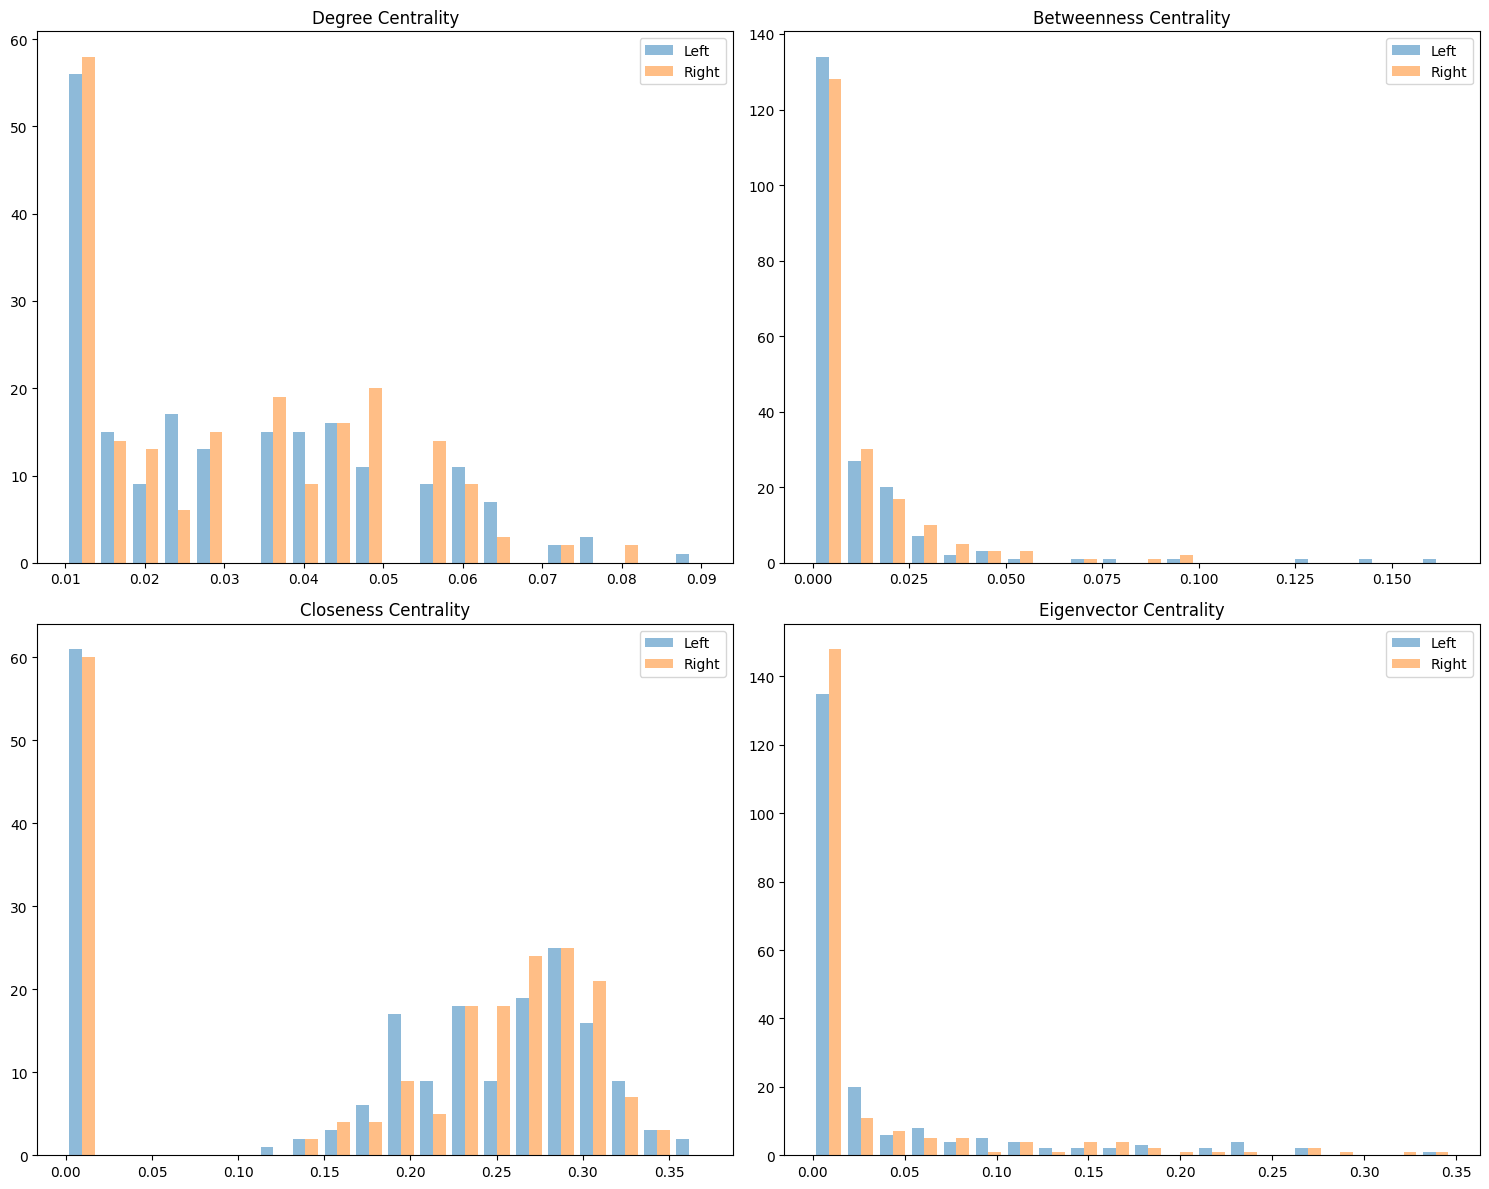

In [29]:
# hub analysis

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_hub_regions(matrix, threshold=0.5):
    """
    Identify and analyze hub regions in each hemisphere
    """
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Create graphs
    G_left = nx.from_numpy_array(left_matrix)
    G_right = nx.from_numpy_array(right_matrix)
    
    def identify_hubs(G):
        # Calculate various centrality metrics
        degree_cent = nx.degree_centrality(G)
        betweenness_cent = nx.betweenness_centrality(G, weight='weight')
        closeness_cent = nx.closeness_centrality(G, distance='weight')
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
        
        return {
            'degree': degree_cent,
            'betweenness': betweenness_cent,
            'closeness': closeness_cent,
            'eigenvector': eigenvector_cent
        }
    
    left_centrality = identify_hubs(G_left)
    right_centrality = identify_hubs(G_right)
    
    # Visualize centrality distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics = ['degree', 'betweenness', 'closeness', 'eigenvector']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        # Convert dictionary values to lists
        left_values = list(left_centrality[metric].values())
        right_values = list(right_centrality[metric].values())
        
        ax.hist([left_values, right_values], label=['Left', 'Right'], 
                bins=20, alpha=0.5)
        ax.set_title(f'{metric.capitalize()} Centrality')
        ax.legend()
    
    plt.tight_layout()
    
    # Identify top hub regions
    def get_top_hubs(centrality_metrics, n=5):
        hubs = {}
        for metric in metrics:
            sorted_nodes = sorted(centrality_metrics[metric].items(),
                                key=lambda x: x[1], reverse=True)
            hubs[metric] = sorted_nodes[:n]
        return hubs
    
    left_hubs = get_top_hubs(left_centrality)
    right_hubs = get_top_hubs(right_centrality)
    
    # Print results
    print("\nTop Hub Regions:")
    for metric in metrics:
        print(f"\n{metric.capitalize()} Centrality:")
        print("\nLeft Hemisphere:")
        for node, value in left_hubs[metric]:
            print(f"Node {node}: {value:.3f}")
        print("\nRight Hemisphere:")
        for node, value in right_hubs[metric]:
            print(f"Node {node}: {value:.3f}")
    
    return {
        'left': left_centrality, 
        'right': right_centrality,
        'left_hubs': left_hubs,
        'right_hubs': right_hubs
    }

# Run analysis
hub_metrics = analyze_hub_regions(matrix, threshold=0.5)


Connection Analysis Summary:
Unique to Left Hemisphere: 708
Unique to Right Hemisphere: 700
Common Connections: 340

Connection Strength Differences (Left - Right):
Mean: -0.004
Std: 0.059
Max: 0.189
Min: -0.294


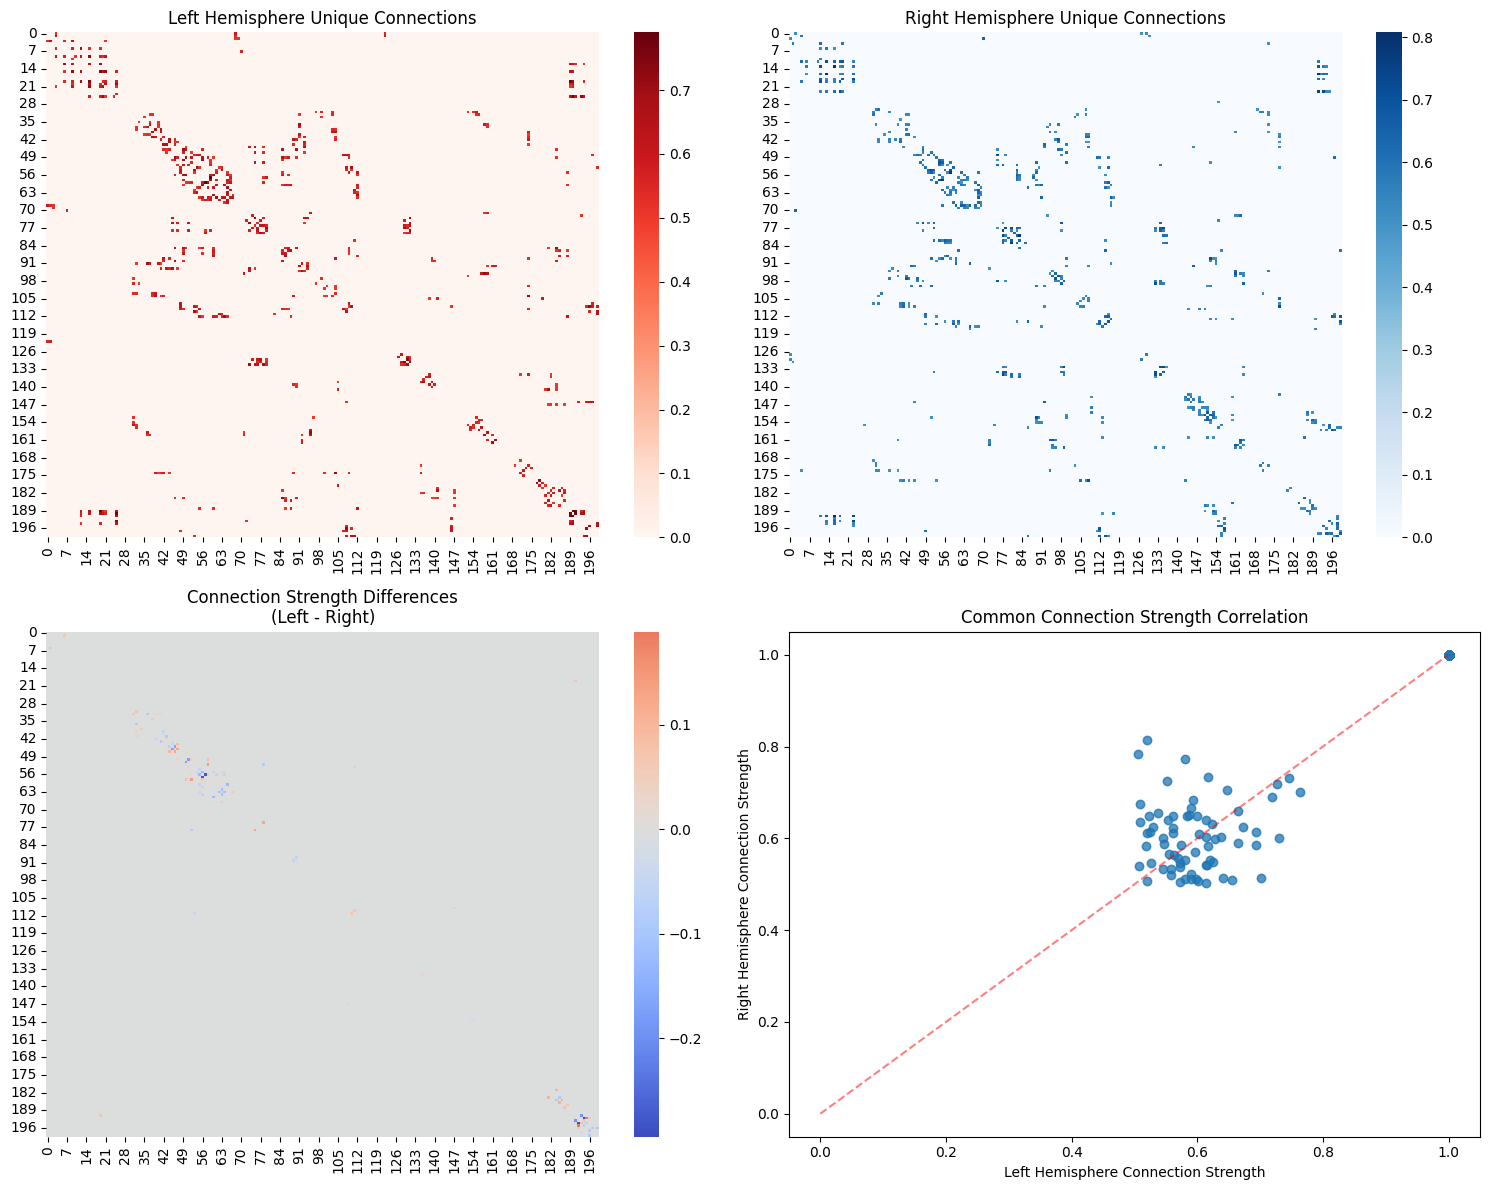

In [ ]:
# connection difference analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_connection_differences(matrix, threshold=0.5):
    """
    Analyze differences in connections between hemispheres
    """
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Find unique connections in each hemisphere
    left_connections = set(map(tuple, np.argwhere(left_matrix != 0)))
    right_connections = set(map(tuple, np.argwhere(right_matrix != 0)))
    
    # Find differential connections
    left_unique = left_connections - right_connections
    right_unique = right_connections - left_connections
    common_connections = left_connections.intersection(right_connections)
    
    # Compare connection strengths for common connections
    strength_diff = np.zeros_like(left_matrix)
    for i, j in common_connections:
        strength_diff[i, j] = left_matrix[i, j] - right_matrix[i, j]
    
    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot unique connections
    left_unique_mat = np.zeros_like(left_matrix)
    right_unique_mat = np.zeros_like(right_matrix)
    
    for i, j in left_unique:
        left_unique_mat[i, j] = left_matrix[i, j]
    for i, j in right_unique:
        right_unique_mat[i, j] = right_matrix[i, j]
    
    sns.heatmap(left_unique_mat, ax=ax1, cmap='Reds')
    ax1.set_title('Left Hemisphere Unique Connections')
    
    sns.heatmap(right_unique_mat, ax=ax2, cmap='Blues')
    ax2.set_title('Right Hemisphere Unique Connections')
    
    # Plot strength differences
    sns.heatmap(strength_diff, ax=ax3, cmap='coolwarm', center=0)
    ax3.set_title('Connection Strength Differences\n(Left - Right)')
    
    # Plot connection strength correlation
    common_left = []
    common_right = []
    for i, j in common_connections:
        common_left.append(left_matrix[i, j])
        common_right.append(right_matrix[i, j])
    
    ax4.scatter(common_left, common_right, alpha=0.5)
    ax4.set_xlabel('Left Hemisphere Connection Strength')
    ax4.set_ylabel('Right Hemisphere Connection Strength')
    ax4.set_title('Common Connection Strength Correlation')
    
    # Add diagonal line for reference
    max_val = max(max(common_left), max(common_right))
    ax4.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nConnection Analysis Summary:")
    print(f"Unique to Left Hemisphere: {len(left_unique)}")
    print(f"Unique to Right Hemisphere: {len(right_unique)}")
    print(f"Common Connections: {len(common_connections)}")
    
    # Analyze strength differences
    strength_diffs = [left_matrix[i, j] - right_matrix[i, j] for i, j in common_connections]
    print(f"\nConnection Strength Differences (Left - Right):")
    print(f"Mean: {np.mean(strength_diffs):.3f}")
    print(f"Std: {np.std(strength_diffs):.3f}")
    print(f"Max: {np.max(strength_diffs):.3f}")
    print(f"Min: {np.min(strength_diffs):.3f}")
    
    return {
        'left_unique': left_unique,
        'right_unique': right_unique,
        'common': common_connections,
        'strength_differences': strength_diffs
    }

# Run analysis
connection_diff = analyze_connection_differences(matrix, threshold=0.5)


Left Hemisphere Top Regions:

Top 5 regions by degree:
1. SomMot_26: 18.000
2. SomMot_19: 15.000
3. SomMot_25: 15.000
4. SomMot_30: 15.000
5. SomMot_35: 14.000

Top 5 regions by strength:
1. SomMot_26: 11.437
2. SomMot_19: 9.631
3. SomMot_30: 9.401
4. SomMot_25: 9.321
5. SomMot_35: 9.057

Top 5 regions by betweenness:
1. SalVentAttn_Med_4: 0.166
2. Default_PFC_10: 0.144
3. SalVentAttn_Med_3: 0.124
4. Default_pCunPCC_7: 0.093
5. SomMot_10: 0.080

Top 5 regions by eigenvector:
1. SomMot_26: 0.347
2. SomMot_30: 0.270
3. SomMot_19: 0.261
4. SomMot_35: 0.243
5. SomMot_28: 0.237

Right Hemisphere Top Regions:

Top 5 regions by degree:
1. SomMot_26: 16.000
2. SomMot_29: 16.000
3. SomMot_23: 14.000
4. SomMot_27: 14.000
5. SomMot_3: 13.000

Top 5 regions by strength:
1. SomMot_26: 10.593
2. SomMot_29: 10.173
3. SomMot_27: 9.338
4. Default_pCunPCC_1: 9.273
5. SomMot_23: 9.079

Top 5 regions by betweenness:
1. Default_PFCv_4: 0.093
2. Default_Temp_8: 0.092
3. SomMot_24: 0.089
4. Vis_5: 0.073
5. 

/tmp/ipykernel_11442/3334584731.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([regions[i] for i in sorted_idx],


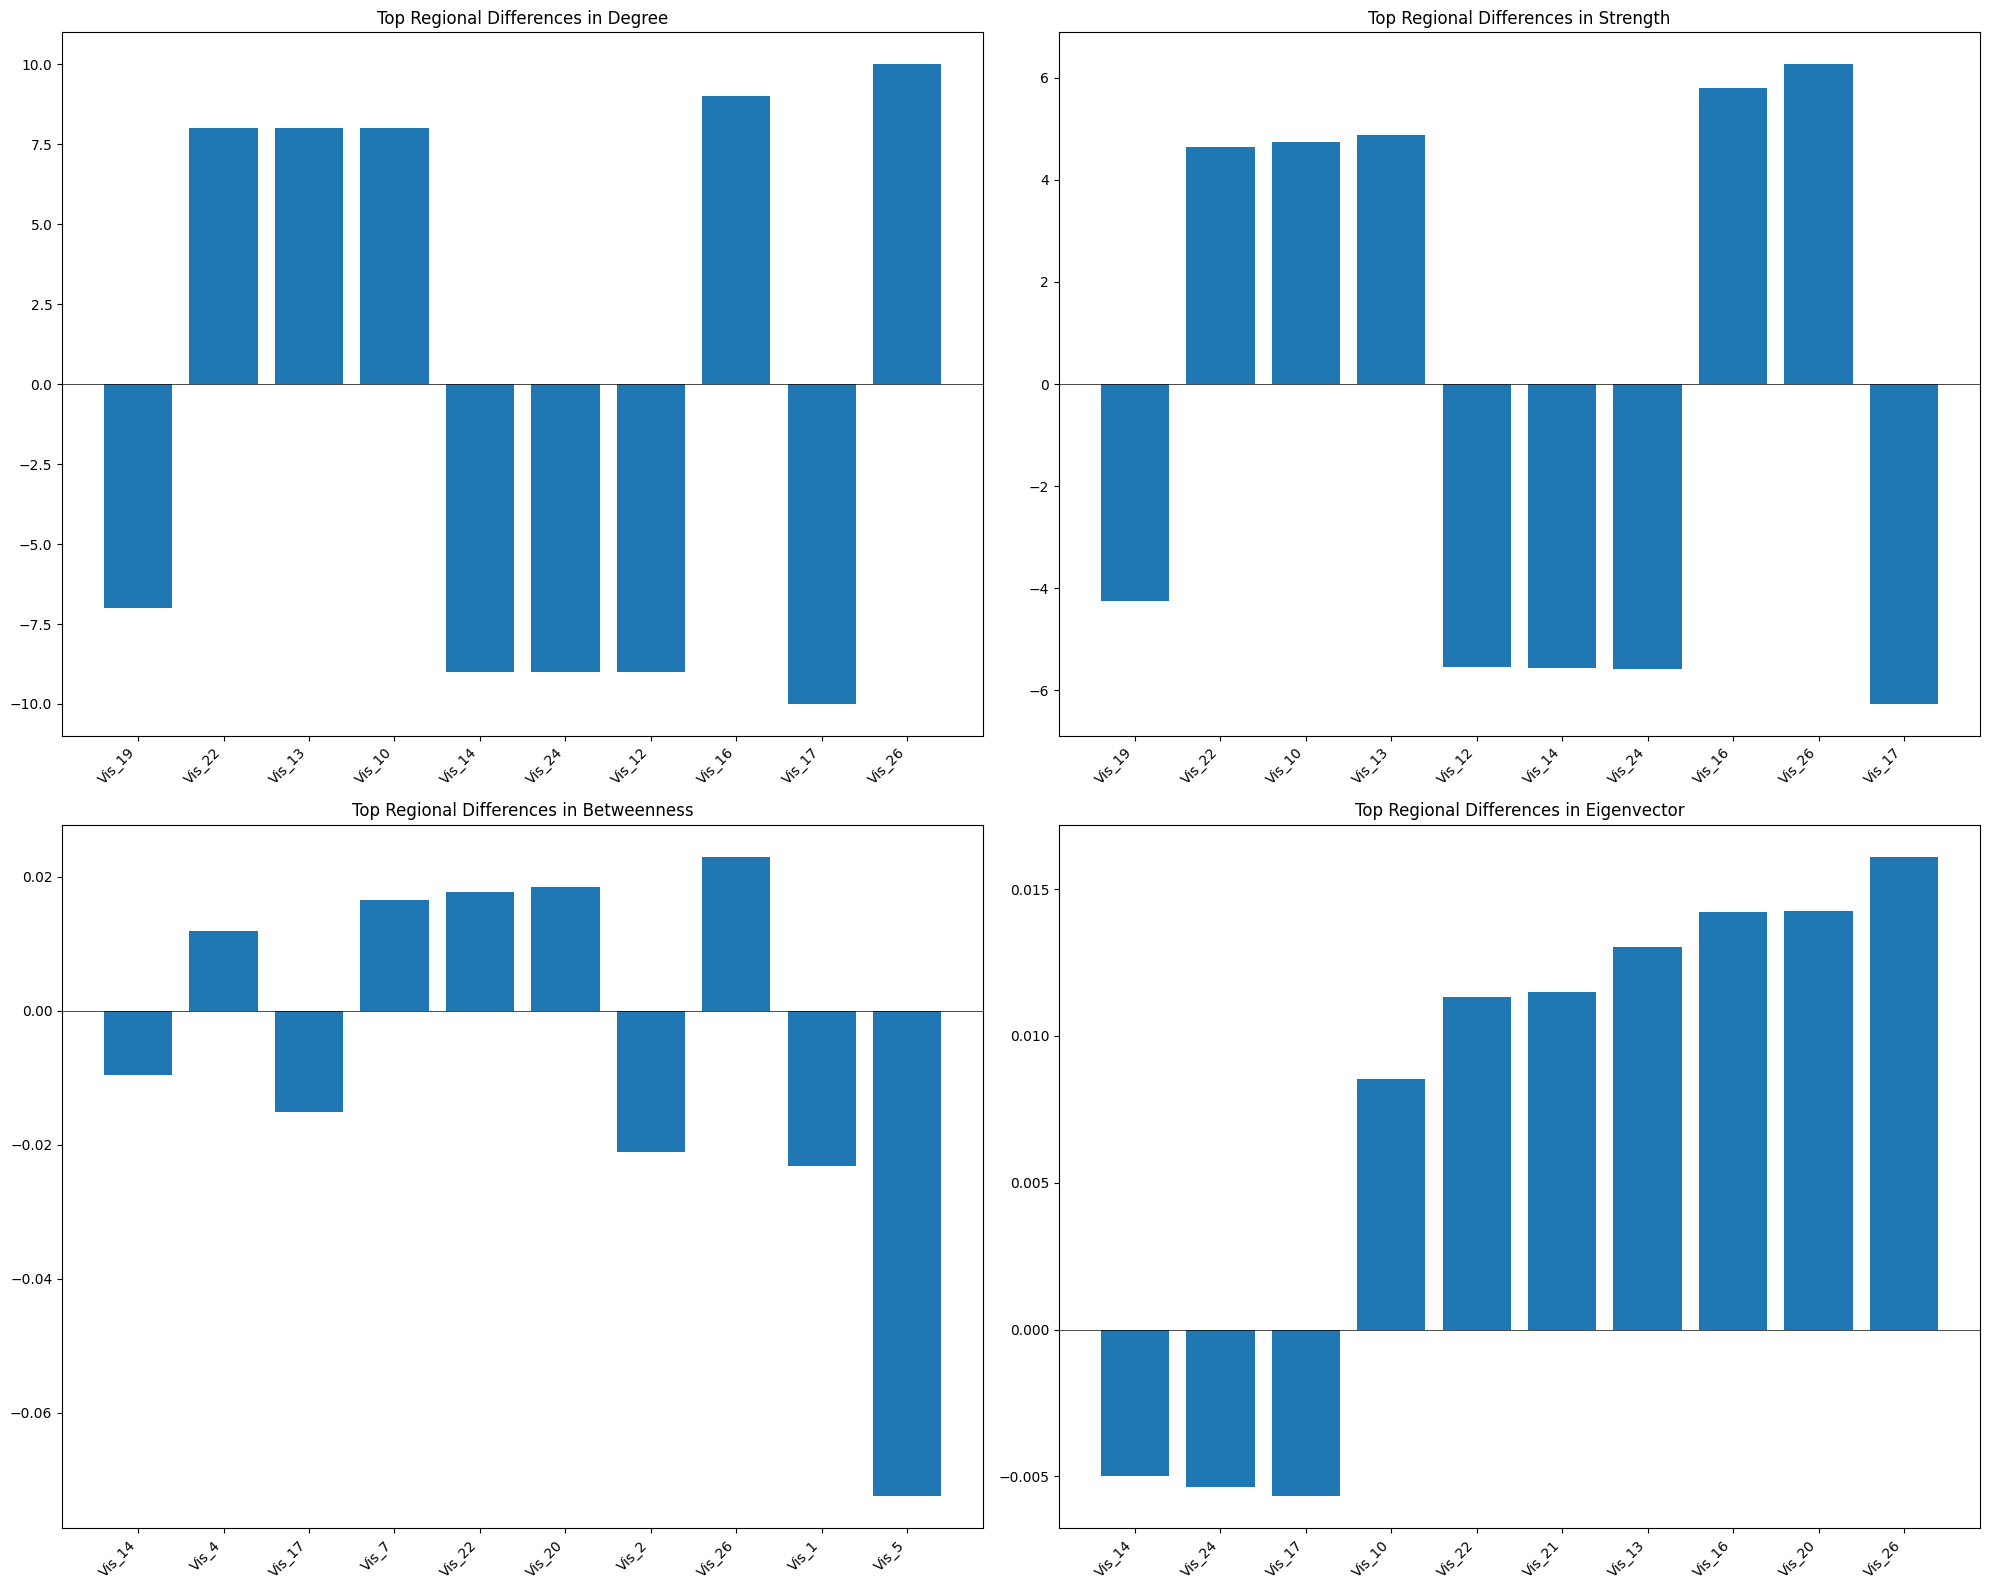

In [4]:
# plot to anatomical 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets

def map_to_anatomy(matrix, threshold=0.5):
    """
    Map network metrics to anatomical regions using Schaefer atlas
    """
    # Get Schaefer atlas labels
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
    labels = atlas.labels.astype('U')
    
    # Clean labels for easier reading
    clean_labels = []
    for label in labels:
        # Remove prefix and hemisphere indicator
        cleaned = label.split('7Networks_')[1] if '7Networks_' in label else label
        cleaned = cleaned.split('_')[1:] if '_' in cleaned else cleaned
        clean_labels.append('_'.join(cleaned))
    
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Create graphs
    G_left = nx.from_numpy_array(left_matrix)
    G_right = nx.from_numpy_array(right_matrix)
    
    # Calculate metrics for each node
    def get_node_metrics(G):
        metrics = {
            'degree': dict(G.degree()),
            'strength': dict(nx.degree(G, weight='weight')),
            'betweenness': nx.betweenness_centrality(G, weight='weight'),
            'eigenvector': nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
        }
        return metrics
    
    left_metrics = get_node_metrics(G_left)
    right_metrics = get_node_metrics(G_right)
    
    # Create summary dataframe-like structure
    left_summary = []
    right_summary = []
    
    # Get top nodes for each metric
    for i in range(mid_point):
        left_data = {
            'node': i,
            'region': clean_labels[i],
            'degree': left_metrics['degree'][i],
            'strength': left_metrics['strength'][i],
            'betweenness': left_metrics['betweenness'][i],
            'eigenvector': left_metrics['eigenvector'][i]
        }
        left_summary.append(left_data)
        
        right_data = {
            'node': i,
            'region': clean_labels[i + mid_point],
            'degree': right_metrics['degree'][i],
            'strength': right_metrics['strength'][i],
            'betweenness': right_metrics['betweenness'][i],
            'eigenvector': right_metrics['eigenvector'][i]
        }
        right_summary.append(right_data)
    
    # Print top regions by different metrics
    def print_top_regions(summary, hemisphere, n=5):
        print(f"\n{hemisphere} Hemisphere Top Regions:")
        
        metrics = ['degree', 'strength', 'betweenness', 'eigenvector']
        for metric in metrics:
            sorted_regions = sorted(summary, key=lambda x: x[metric], reverse=True)[:n]
            print(f"\nTop {n} regions by {metric}:")
            for idx, region in enumerate(sorted_regions, 1):
                print(f"{idx}. {region['region']}: {region[metric]:.3f}")
    
    print_top_regions(left_summary, "Left")
    print_top_regions(right_summary, "Right")
    
    # Plot regional differences
    def plot_regional_differences(left_summary, right_summary):
        metrics = ['degree', 'strength', 'betweenness', 'eigenvector']
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx//2, idx%2]
            
            # Calculate differences
            differences = []
            regions = []
            for l, r in zip(left_summary, right_summary):
                if l['region'] == r['region']:  # matching regions
                    differences.append(l[metric] - r[metric])
                    regions.append(l['region'])
            
            # Sort by absolute difference
            sorted_idx = np.argsort(np.abs(differences))[-10:]  # top 10 differences
            
            # Plot vertical bars instead of horizontal
            ax.bar([regions[i] for i in sorted_idx], 
                [differences[i] for i in sorted_idx])
            
            # Rotate x-axis labels for better readability
            ax.set_xticklabels([regions[i] for i in sorted_idx], 
                            rotation=45, 
                            ha='right')
            
            ax.set_title(f'Top Regional Differences in {metric.capitalize()}')
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            
        plt.tight_layout()
        return fig
    
    plot_regional_differences(left_summary, right_summary)
    
    return left_summary, right_summary

# Run analysis
left_summary, right_summary = map_to_anatomy(matrix, threshold=0.5)

Total number of connections: 21170
Number of connections above threshold: 148
Percentage of connections retained: 0.70%


<Figure size 800x800 with 0 Axes>

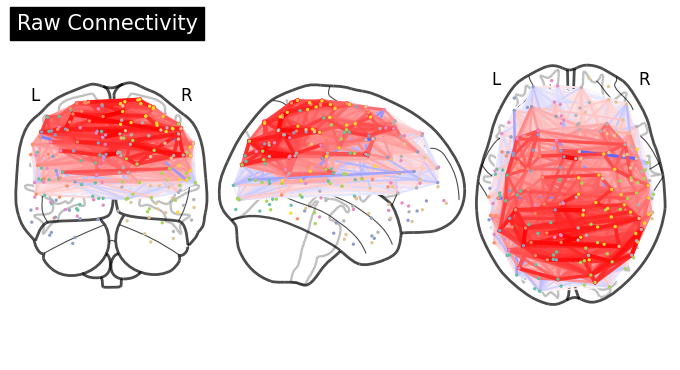

<Figure size 800x800 with 0 Axes>

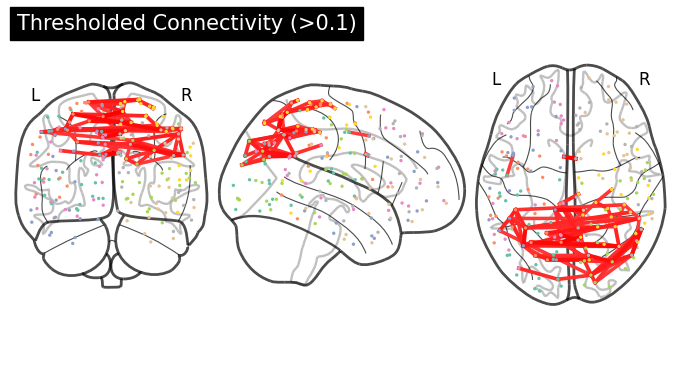

In [33]:
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Create two separate figures
# Plot 1: Raw connectivity
fig1 = plt.figure(figsize=(8, 8))
display = plotting.plot_connectome(matrix, coords,
                                 node_color='auto',
                                 node_size=2,
                                 edge_threshold='2%',  # Show top 5% strongest connections
                                 title="Raw Connectivity")

# Plot 2: Thresholded connectivity
fig2 = plt.figure(figsize=(8, 8))
# Apply threshold to matrix
threshold = 0.6
thresholded_matrix = matrix.copy()
thresholded_matrix[np.abs(thresholded_matrix) < threshold] = 0

display = plotting.plot_connectome(thresholded_matrix, coords,
                                 node_color='auto',
                                 node_size=2,
                                 edge_threshold=None,  # No additional thresholding
                                 title="Thresholded Connectivity (>0.1)")

# Print some connectivity statistics
n_connections = np.sum(np.abs(matrix) > 0) - np.sum(np.diag(np.abs(matrix) > 0))
n_thresholded = np.sum(np.abs(thresholded_matrix) > 0) - np.sum(np.diag(np.abs(thresholded_matrix) > 0))

print(f"Total number of connections: {n_connections}")
print(f"Number of connections above threshold: {n_thresholded}")
print(f"Percentage of connections retained: {(n_thresholded/n_connections)*100:.2f}%")

# Create an interactive plot
view = plotting.view_connectome(thresholded_matrix, coords,
                              node_color='auto',
                              node_size=2,
                              edge_threshold=None)
view.open_in_browser()

plt.show()


Connectivity Statistics:
Total number of regions: 200
Number of connected regions: 146
Percentage of regions with strong connections: 73.00%
Number of strong connections: 3980
Connection density among connected nodes: 37.60%
Connection threshold value: 0.100


<Figure size 1000x1000 with 0 Axes>

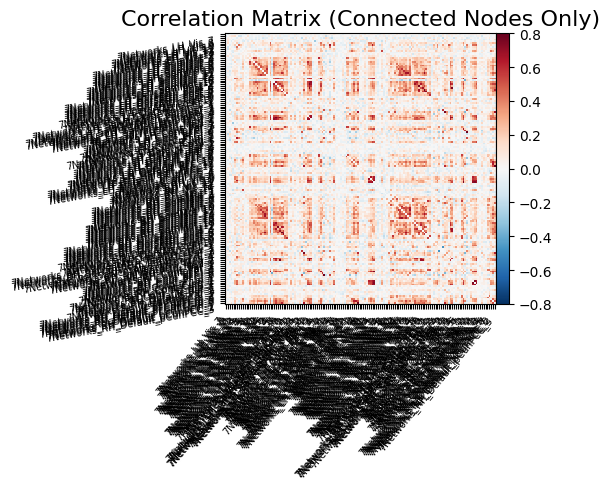

<Figure size 1000x1000 with 0 Axes>

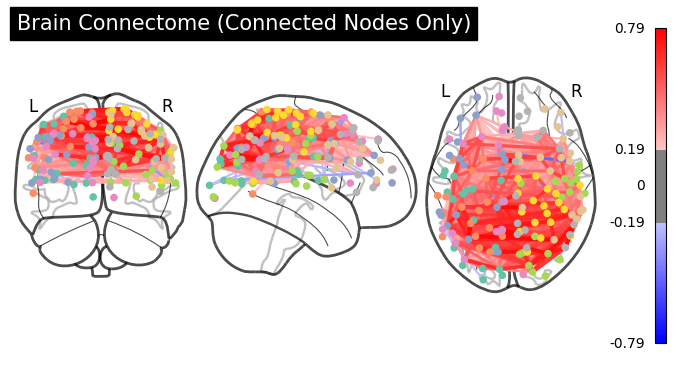

In [34]:
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = [label.decode() if isinstance(label, bytes) else label for label in atlas.labels]

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Create a mask for connected nodes
# First, get the threshold value (80th percentile of absolute values)
threshold = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 80)

# Find nodes that have any connections above threshold
connected_nodes = np.where(np.any(np.abs(matrix) > threshold, axis=0))[0]

# Create masked versions of the matrix, coordinates, and labels
matrix_masked = matrix[np.ix_(connected_nodes, connected_nodes)]
coords_masked = coords[connected_nodes]
labels_masked = [labels[i] for i in connected_nodes]

# Display the correlation matrix for connected nodes only
plt.figure(figsize=(10, 10))
matrix_plot = matrix_masked.copy()
np.fill_diagonal(matrix_plot, 0)
plotting.plot_matrix(
    matrix_plot,
    labels=labels_masked,
    colorbar=True,
    vmax=0.8,
    vmin=-0.8,
    title="Correlation Matrix (Connected Nodes Only)"
)

# Create connectome plot
plt.figure(figsize=(10, 10))
plotting.plot_connectome(
    matrix_masked,
    coords_masked,
    edge_threshold="80%",  # Keep top 20% of connections
    node_color='auto',
    node_size=20,  # Increased node size for better visibility
    title="Brain Connectome (Connected Nodes Only)",
    colorbar=True
)

# Create an interactive visualization
view = plotting.view_connectome(
    matrix_masked,
    coords_masked,
    edge_threshold="80%",
    node_color='auto',
    node_size=30
)

# Open the interactive plot in a browser
view.open_in_browser()

# Print statistics about the connectivity
total_nodes = len(matrix)
connected_node_count = len(connected_nodes)
total_possible_connections = (connected_node_count * (connected_node_count - 1)) / 2
strong_connections = np.sum(np.abs(matrix_masked) > threshold) / 2  # Divide by 2 to not count connections twice

print(f"\nConnectivity Statistics:")
print(f"Total number of regions: {total_nodes}")
print(f"Number of connected regions: {connected_node_count}")
print(f"Percentage of regions with strong connections: {(connected_node_count/total_nodes)*100:.2f}%")
print(f"Number of strong connections: {int(strong_connections)}")
print(f"Connection density among connected nodes: {(strong_connections/total_possible_connections)*100:.2f}%")
print(f"Connection threshold value: {threshold:.3f}")

plt.show()

Found 19 connectivity matrices
Computing persistent homology...



Topology Analysis Results:
Number of connected components (β0): 129
Number of cycles (β1): 245


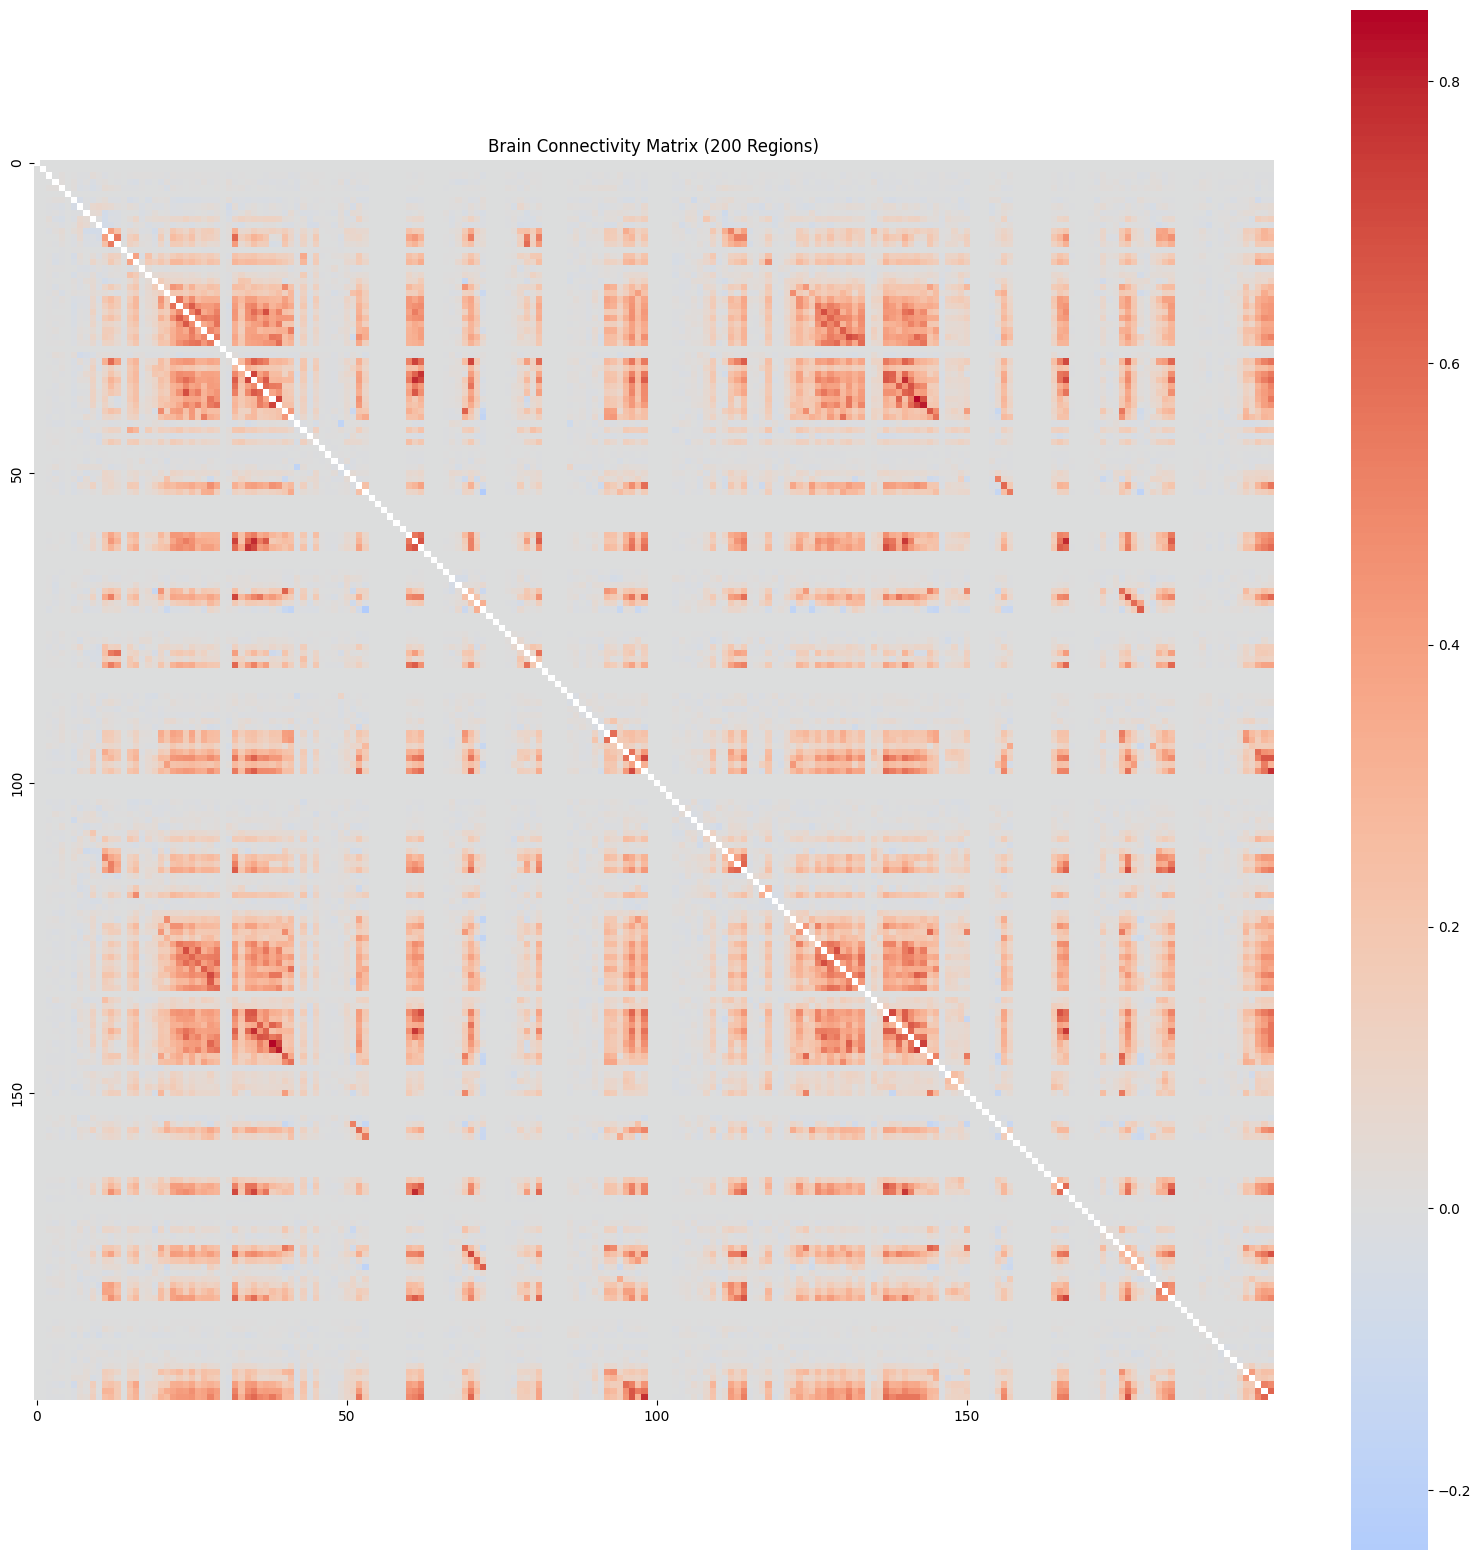

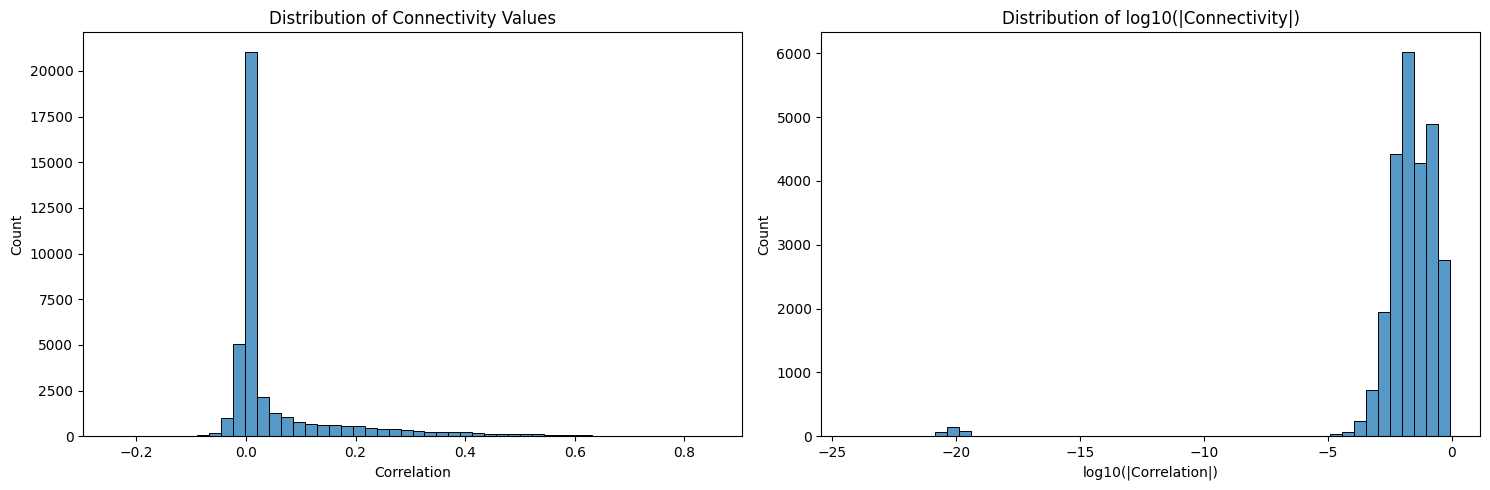

<Figure size 1200x800 with 0 Axes>

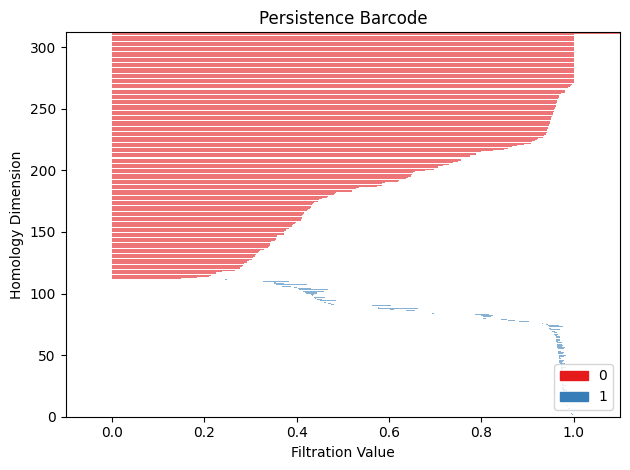

<Figure size 1000x1000 with 0 Axes>

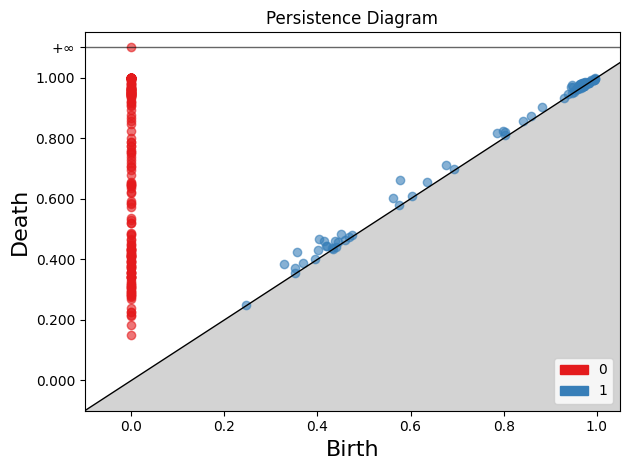

<Figure size 1000x800 with 0 Axes>

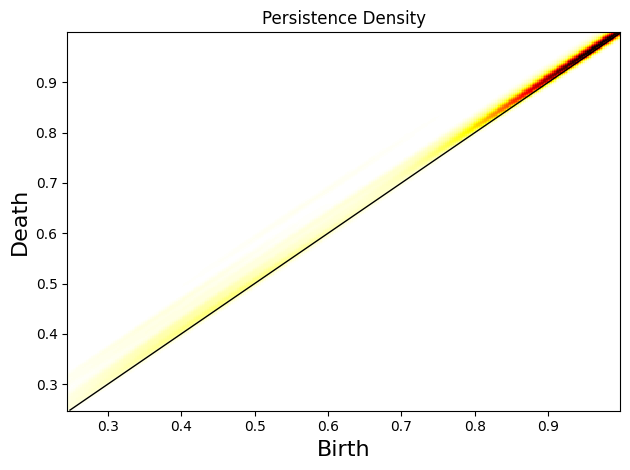

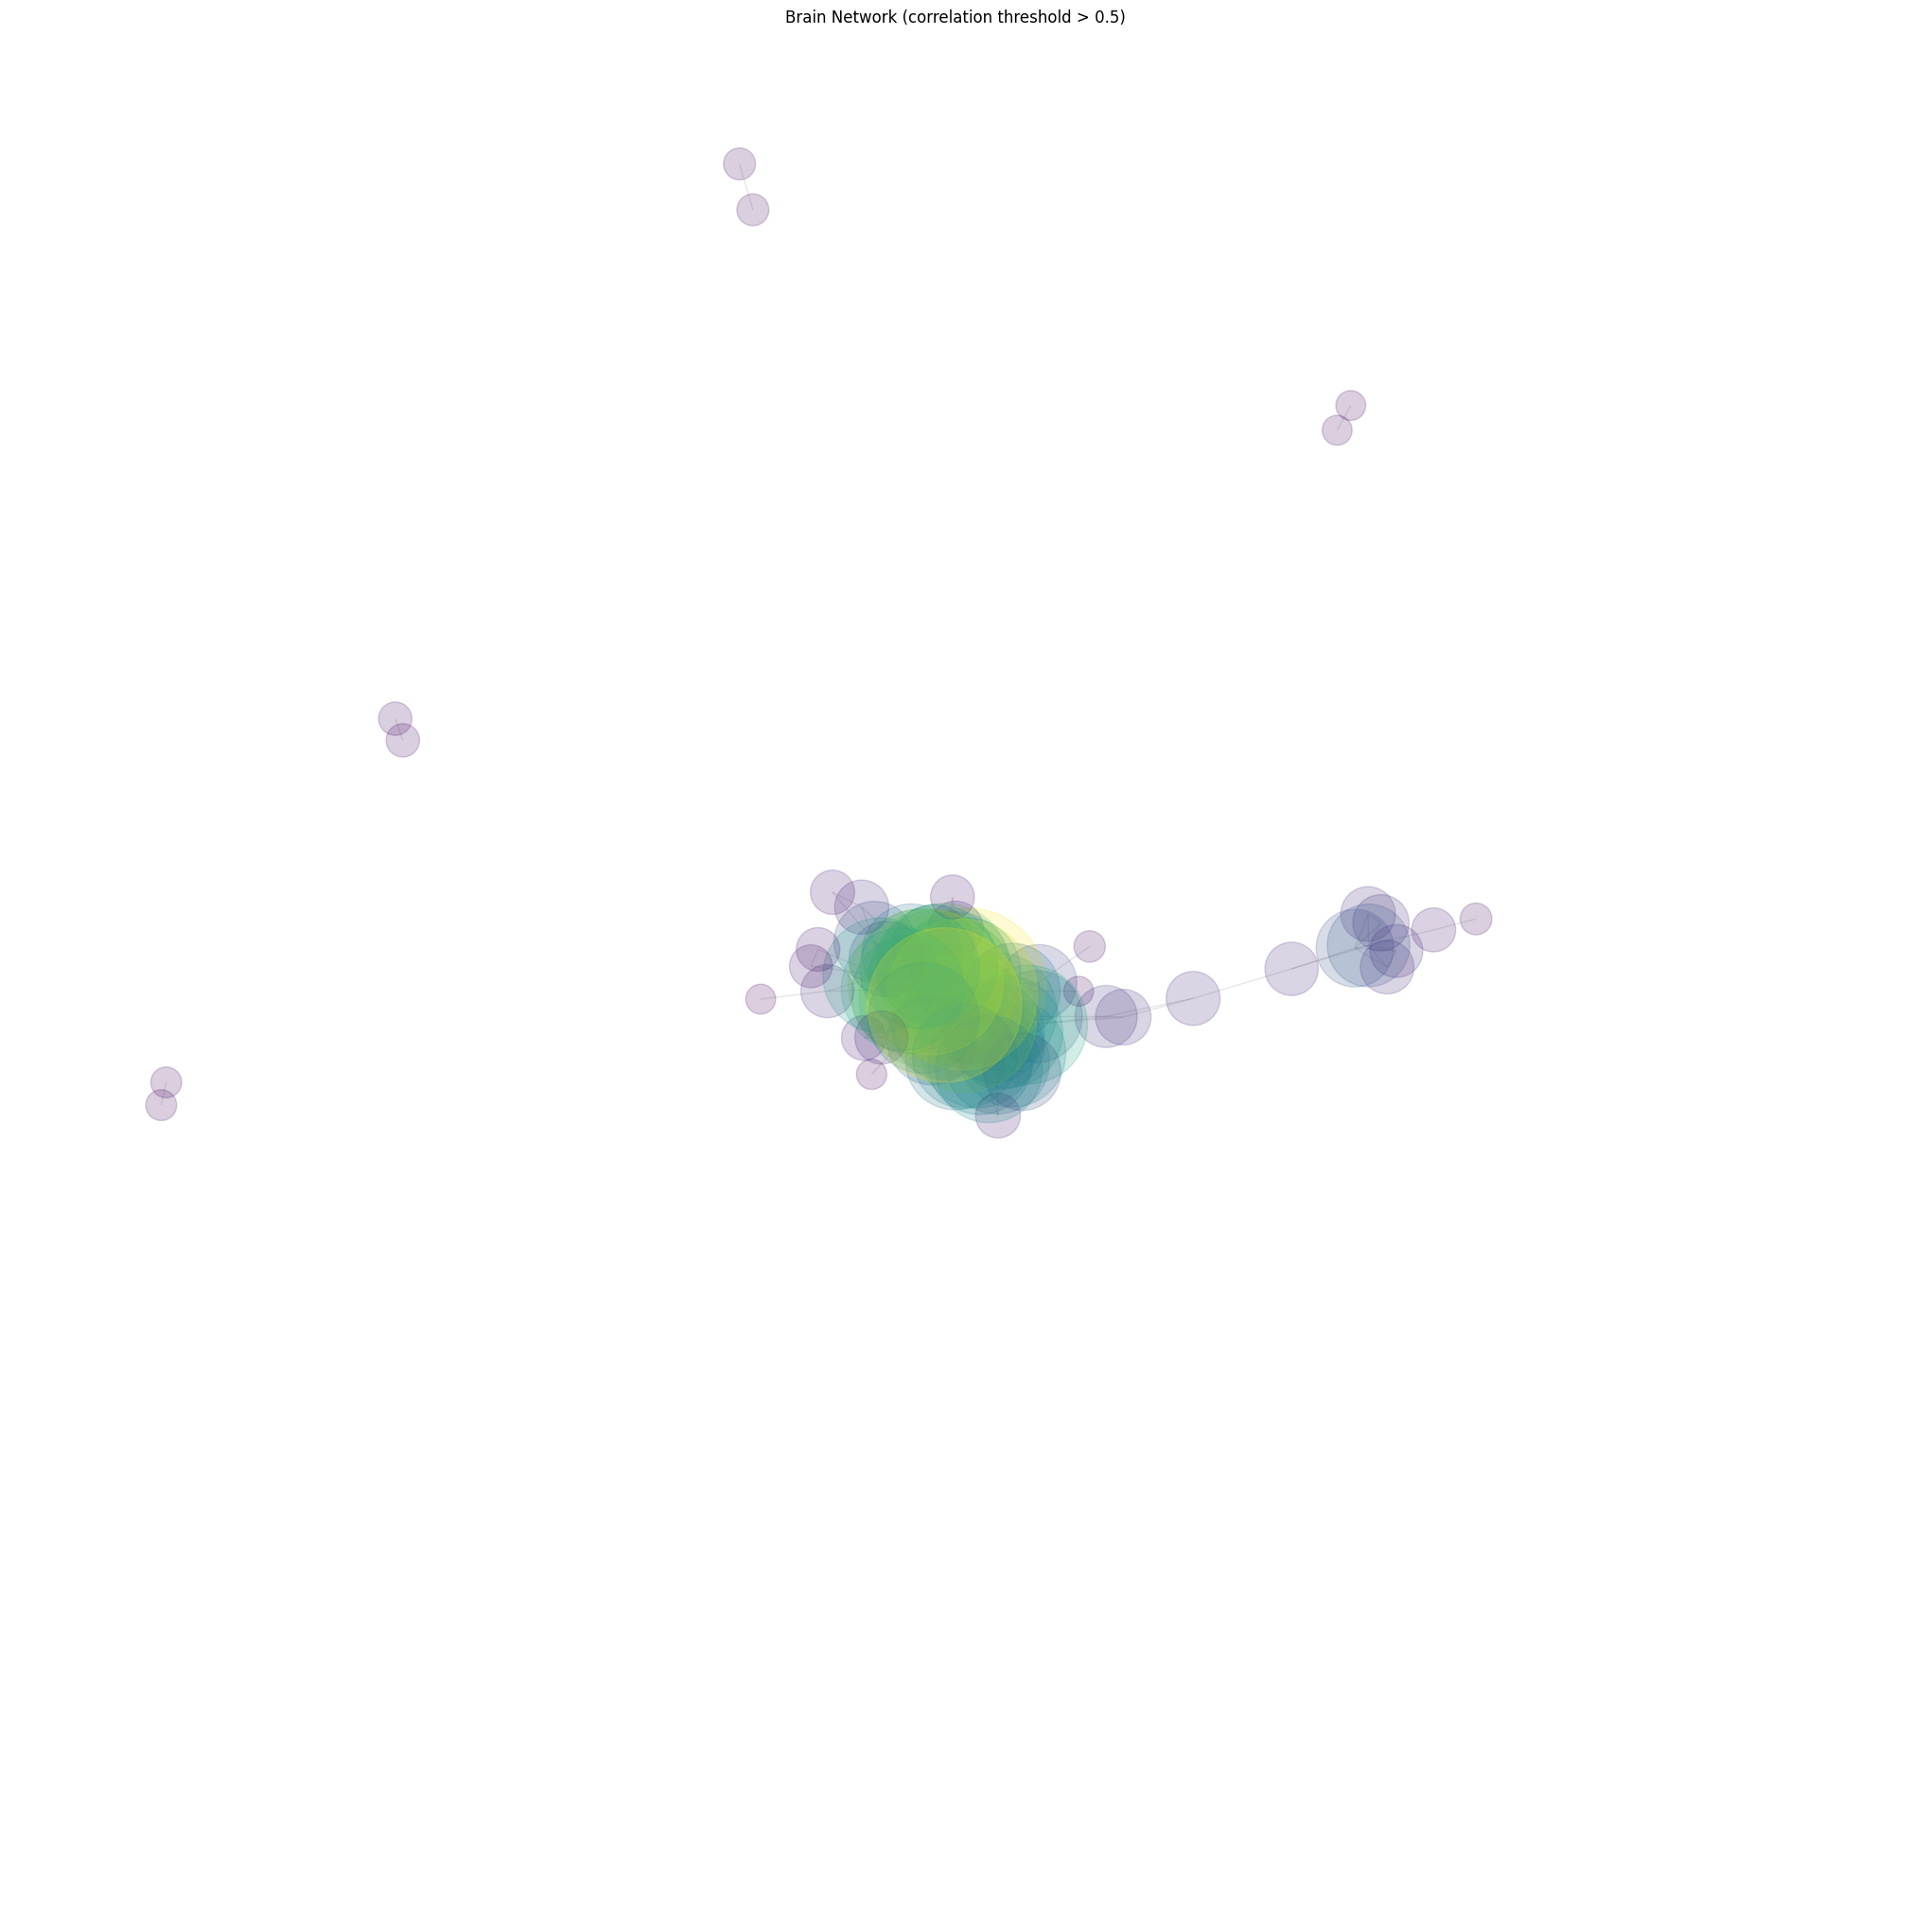

In [35]:
# topology and geometry analysis and visualization
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gudhi

def create_all_visualizations(matrix, region_labels, results_dir):
    """
    Create all visualizations including topology analysis
    """
    # 1. Basic Heatmap
    plt.figure(figsize=(20, 20))
    matrix_plot = matrix.copy()
    np.fill_diagonal(matrix_plot, np.nan)
    sns.heatmap(matrix_plot, 
                cmap='coolwarm',
                center=0,
                square=True,
                xticklabels=50,
                yticklabels=50)
    plt.title('Brain Connectivity Matrix (200 Regions)')
    
    # 2. Distribution Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    flat_matrix = matrix_plot[~np.isnan(matrix_plot)]
    
    # Raw distribution
    sns.histplot(flat_matrix, bins=50, ax=ax1)
    ax1.set_title('Distribution of Connectivity Values')
    ax1.set_xlabel('Correlation')
    ax1.set_ylabel('Count')
    
    # Log10 distribution
    sns.histplot(np.log10(np.abs(flat_matrix)), bins=50, ax=ax2)
    ax2.set_title('Distribution of log10(|Connectivity|)')
    ax2.set_xlabel('log10(|Correlation|)')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    
    # 3. Topology Analysis
    print("Computing persistent homology...")
    mattop = 1 - matrix_plot[~np.isnan(matrix_plot)].reshape(200, 199)  # Reshape to remove diagonal
    
    # Computing persistence
    rips_complex = gudhi.RipsComplex(distance_matrix=mattop, max_edge_length=1)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    
    # Persistence Barcode
    plt.figure(figsize=(12, 8))
    gudhi.plot_persistence_barcode(diag, legend=True, max_intervals=0)
    plt.title('Persistence Barcode')
    plt.xlabel('Filtration Value')
    plt.ylabel('Homology Dimension')
    plt.tight_layout()
    
    # Persistence Diagram 
    plt.figure(figsize=(10, 10))
    gudhi.plot_persistence_diagram(diag, legend=True, max_intervals=0)
    plt.title('Persistence Diagram')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.tight_layout()
    
    # Persistence density
    plt.figure(figsize=(10, 8))
    gudhi.plot_persistence_density(diag, dimension=1)
    plt.title('Persistence Density')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.tight_layout()
    
    # 4. Network Analysis (your existing code)
    G = nx.from_numpy_array(matrix)
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    
    threshold = 0.5
    for (u, v, d) in list(G.edges(data=True)):
        if abs(d['weight']) < threshold:
            G.remove_edge(u, v)
            
    node_strength = dict(nx.degree(G, weight='weight'))
    node_sizes = [abs(v) * 1000 for v in node_strength.values()]
    
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    nx.draw(G, pos,
            node_size=node_sizes,
            node_color=list(node_strength.values()),
            cmap=plt.cm.viridis,
            edge_color='gray',
            alpha=0.2,
            with_labels=False)
    plt.title(f'Brain Network (correlation threshold > {threshold})')

    # Compute and print topology metrics
    betti_numbers = {
        'beta0': nx.number_connected_components(G),
        'beta1': len(G.edges()) - len(G.nodes()) + nx.number_connected_components(G)
    }
    
    print("\nTopology Analysis Results:")
    print(f"Number of connected components (β0): {betti_numbers['beta0']}")
    print(f"Number of cycles (β1): {betti_numbers['beta1']}")

# Run the visualization
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Create all visualizations
create_all_visualizations(matrix, region_labels, results_dir)

# Show all plots
plt.show()